In [4]:
from __future__ import annotations

from pathlib import Path
from datetime import date, timedelta
from collections import Counter, defaultdict
import glob
import gc

import polars as pl
import matplotlib.pyplot as plt
import sqlite3
import math
import heapq
import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import polars as pl
from tqdm.auto import tqdm


In [ ]:
path = "/media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet"
df = pl.read_parquet(path)

print(df.schema)
print(df.select(pl.col("dir").cast(pl.Utf8).str.to_lowercase().unique()))
print(df.group_by("dir").agg(
    pl.len().alias("rows"),
    pl.col("address").is_null().sum().alias("addr_nulls"),
    pl.col("address").is_not_null().sum().alias("addr_nonnulls"),
))


Schema({'dir': String, 'height': Int64, 'time': Datetime(time_unit='ns', time_zone=None), 'txid': String, 'n': Int64, 'prev_txid': String, 'prev_vout': Float64, 'address': String, 'value': Float64})
shape: (2, 1)
┌─────┐
│ dir │
│ --- │
│ str │
╞═════╡
│ in  │
│ out │
└─────┘
shape: (2, 4)
┌─────┬───────┬────────────┬───────────────┐
│ dir ┆ rows  ┆ addr_nulls ┆ addr_nonnulls │
│ --- ┆ ---   ┆ ---        ┆ ---           │
│ str ┆ u32   ┆ u32        ┆ u32           │
╞═════╪═══════╪════════════╪═══════════════╡
│ in  ┆ 66890 ┆ 66890      ┆ 0             │
│ out ┆ 78996 ┆ 925        ┆ 78071         │
└─────┴───────┴────────────┴───────────────┘


In [ ]:
# -----------------------------
# Sanity checks
# -----------------------------
# Assumes you already computed:
#   - n_nodes (int): number of UF nodes / unique addresses created
#   - node_to_entity (list[int]) OR cluster_size_counter (Counter[int])
# Optional (prevout hit-rate):
#   - prevout_lookups (int)
#   - prevout_hits (int)

def run_sanity_checks(
    n_nodes: int,
    node_to_entity: list[int] | None = None,
    cluster_size_counter: Counter | None = None,
    prevout_lookups: int | None = None,
    prevout_hits: int | None = None,
    top_k: int = 20,
) -> None:
    """
    Prints:
      - largest cluster fraction of nodes
      - top cluster sizes
      - entity count stats
      - optional prevout hit-rate
    Provide either node_to_entity OR cluster_size_counter.
    """
    if cluster_size_counter is None:
        if node_to_entity is None:
            raise ValueError("Provide either node_to_entity or cluster_size_counter.")
        cluster_size_counter = Counter(node_to_entity)

    sizes = list(cluster_size_counter.values())
    if not sizes:
        print("[SANITY] No clusters found (sizes empty).")
        return

    sizes_sorted = sorted(sizes, reverse=True)
    total_nodes_from_sizes = sum(sizes_sorted)
    largest = sizes_sorted[0]
    frac = largest / total_nodes_from_sizes if total_nodes_from_sizes else float("nan")

    print("\n[SANITY] Cluster summary")
    print(f"  UF nodes (n_nodes): {n_nodes}")
    print(f"  Total nodes from cluster sizes: {total_nodes_from_sizes}")
    if total_nodes_from_sizes != n_nodes:
        print("  [WARN] sum(cluster_sizes) != n_nodes  -> mismatch suggests a bug in mapping logic.")
    print(f"  Entities (clusters): {len(cluster_size_counter)}")
    print(f"  Largest cluster size: {largest}")
    print(f"  Largest cluster fraction of nodes: {frac:.2%}")

    print(f"\n[SANITY] Top {top_k} cluster sizes:")
    print(" ", sizes_sorted[:top_k])

    # A couple more helpful distribution points
    def pct(p: float) -> int:
        # nearest-rank percentile
        if not sizes_sorted:
            return 0
        idx = max(0, min(len(sizes_sorted) - 1, math.ceil(p * len(sizes_sorted)) - 1))
        return sorted(sizes_sorted)[idx]

    med = sorted(sizes_sorted)[len(sizes_sorted) // 2]
    print("\n[SANITY] Quick distribution stats")
    print(f"  Median cluster size: {med}")
    print(f"  90th percentile cluster size: {pct(0.90)}")
    print(f"  99th percentile cluster size: {pct(0.99)}")

    if prevout_lookups is not None and prevout_hits is not None:
        rate = (prevout_hits / prevout_lookups) if prevout_lookups else float("nan")
        print("\n[SANITY] Prevout lookup hit-rate")
        print(f"  Lookups: {prevout_lookups}")
        print(f"  Hits:    {prevout_hits}")
        print(f"  Hit-rate: {rate:.2%}")



run_sanity_checks(
     n_nodes=n_nodes,
     node_to_entity=node_to_entity,
 )


[SANITY] Cluster summary
  UF nodes (n_nodes): 14291976
  Total nodes from cluster sizes: 14291976
  Entities (clusters): 1720337
  Largest cluster size: 7883239
  Largest cluster fraction of nodes: 55.16%

[SANITY] Top 20 cluster sizes:
  [7883239, 62912, 23467, 13000, 10394, 9882, 9792, 8781, 7194, 5404, 4332, 3422, 3381, 3165, 2988, 2697, 2575, 2429, 2398, 2269]

[SANITY] Quick distribution stats
  Median cluster size: 2
  90th percentile cluster size: 6
  99th percentile cluster size: 23


In [ ]:
OUTPUT_DIR_VALUES = {"out", "vout", "output", "o"}
INPUT_DIR_VALUES  = {"in", "vin", "input", "i"}

def prevout_join_sanity(one_io_parquet: str) -> None:
    df = pl.read_parquet(one_io_parquet, columns=["dir","txid","n","prev_txid","prev_vout","address","value"])

    df = df.with_columns(
        pl.col("dir").cast(pl.Utf8).str.to_lowercase().alias("dir")
    )

    vout = (
        df.filter(pl.col("dir").is_in(list(OUTPUT_DIR_VALUES)))
          .select([
              pl.col("txid").alias("out_txid"),
              pl.col("n").cast(pl.Int64).alias("out_n"),
              pl.col("address").alias("out_address"),
              pl.col("value").alias("out_value"),
          ])
    )

    vin = (
        df.filter(pl.col("dir").is_in(list(INPUT_DIR_VALUES)))
          .select([
              pl.col("txid").alias("spend_txid"),
              pl.col("prev_txid").alias("prev_txid"),
              pl.col("prev_vout").alias("prev_vout"),
          ])
    )

    print("Rows:", {"vin": vin.height, "vout": vout.height})

    # 1) Check prev_vout is integer-like (Float64 in your schema is suspicious)
    vin_nonnull = vin.filter(pl.col("prev_vout").is_not_null())
    if vin_nonnull.height > 0:
        frac_integerlike = (
            vin_nonnull
            .with_columns(((pl.col("prev_vout") - pl.col("prev_vout").floor()).abs() < 1e-9).alias("is_intlike"))
            .select(pl.col("is_intlike").mean())
            .item()
        )
        print(f"prev_vout integer-like fraction: {frac_integerlike:.6f}")

    # Cast prev_vout safely to int for joining
    vin2 = vin.with_columns(
        pl.when(pl.col("prev_vout").is_not_null())
          .then(pl.col("prev_vout").cast(pl.Int64))
          .otherwise(None)
          .alias("prev_vout_i64")
    )

    # 2) Check uniqueness of outpoints (out_txid, out_n) should be unique
    dupe_outpoints = (
        vout.group_by(["out_txid","out_n"])
            .len()
            .filter(pl.col("len") > 1)
            .height
    )
    print("Duplicate outpoints (should be 0):", dupe_outpoints)

    # 3) Join vin prevouts -> vout outpoints
    joined = (
        vin2.join(
            vout,
            left_on=["prev_txid","prev_vout_i64"],
            right_on=["out_txid","out_n"],
            how="left",
        )
    )

    resolved = joined.filter(pl.col("out_address").is_not_null()).height
    lookups  = vin.height
    print(f"Prevout resolution hit-rate: {resolved}/{lookups} = {resolved/lookups:.2%}" if lookups else "No vin rows")

    # 4) Check for join explosion: each input should match <= 1 output
    max_matches_per_input = (
        joined.group_by(["spend_txid","prev_txid","prev_vout_i64"])
              .len()
              .select(pl.col("len").max())
              .item()
    )
    print("Max matches per (spend_txid, prev_txid, prev_vout):", max_matches_per_input)

    # Optional: show some unresolved examples
    sample_unresolved = (
        joined.filter(pl.col("out_address").is_null())
              .select(["spend_txid","prev_txid","prev_vout_i64"])
              .head(5)
    )
    print("\nSample unresolved inputs:")
    print(sample_unresolved)


prevout_join_sanity("/media/vatereal/Main/parquet/io/day=2013-01-01/io-....parquet")


FileNotFoundError: No such file or directory (os error 2): /media/vatereal/Main/parquet/io/day=2013-01-01/io-....parquet

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'select'
	[3] 'sink'


Parquet file counts: {'io': 7678}
[INFO] Analysis window: 2013-01-01 .. 2014-01-01 (exclusive)
[INFO] Outpoint DB preload start: 2012-01-02 .. 2014-01-01 (exclusive)
Found 7678 io parquet files (all years).
[INFO] Outpoint DB: /media/vatereal/Main/outputs/outpoints_2013.sqlite (reset=True)
[preload 1] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-02/io-000160190-000160340.parquet (day=2012-01-02) ...
[preload 2] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-03/io-000160341-000160499.parquet (day=2012-01-03) ...
[preload 3] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-04/io-000160500-000160648.parquet (day=2012-01-04) ...
[1] Processing /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet (day=2013-01-01) ...
  [debug] distinct dir values in first processed file: ['out', 'in']
[2] Processing /media/vatereal/Main/parquet/io/day=2013-01-02/io-000214725-000214877.parquet (day=2013-01-02) ...
[3] Proces

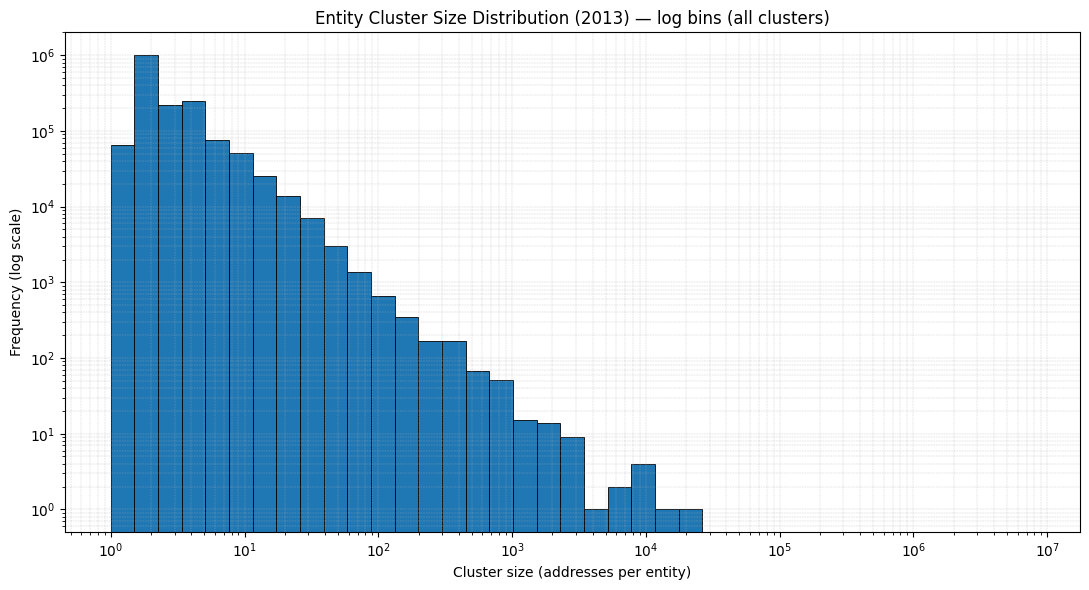

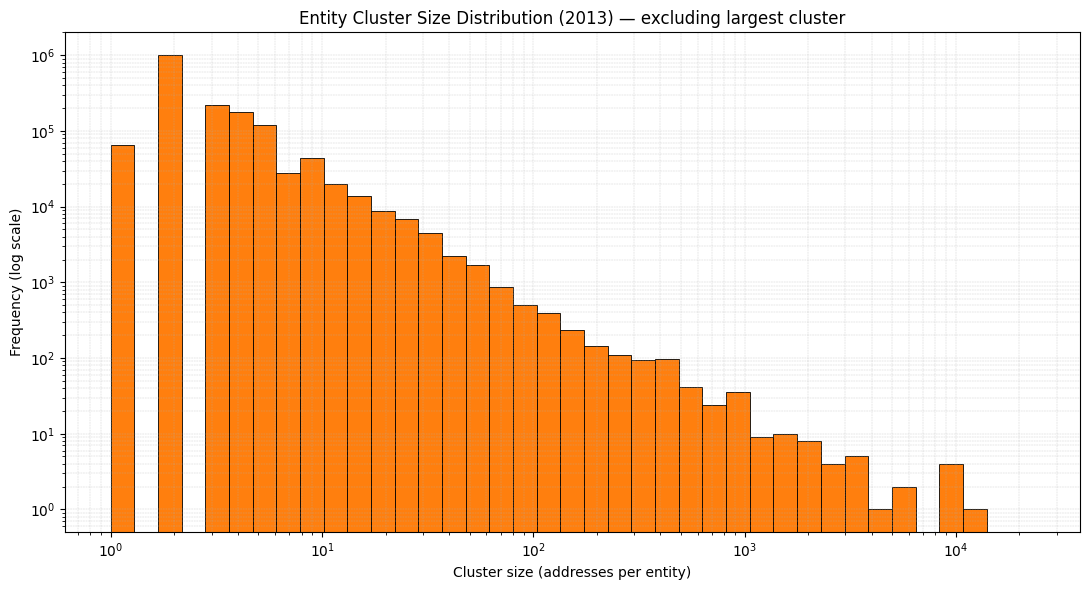

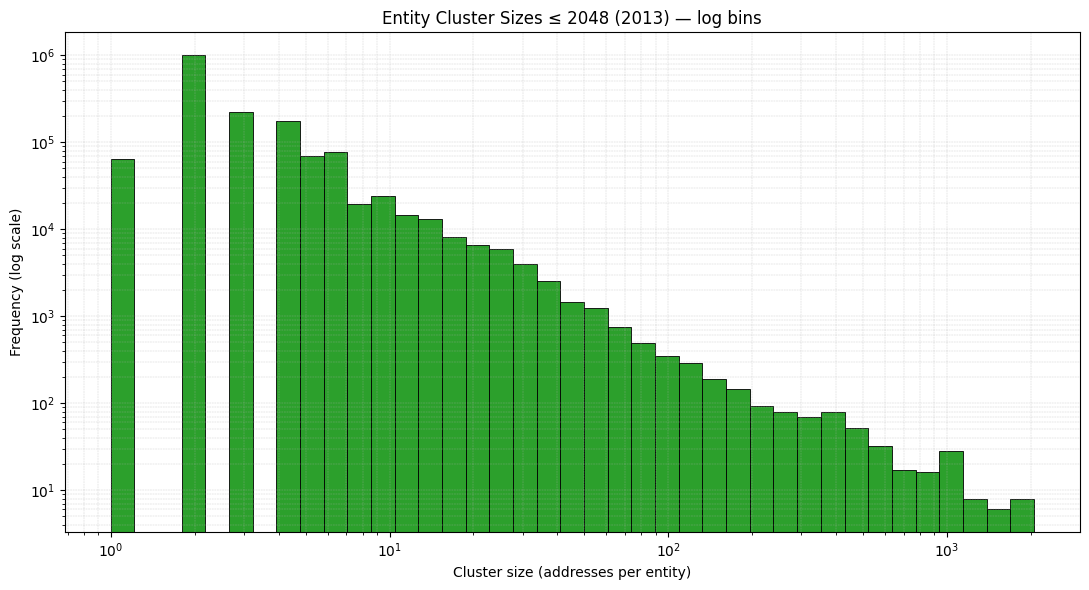

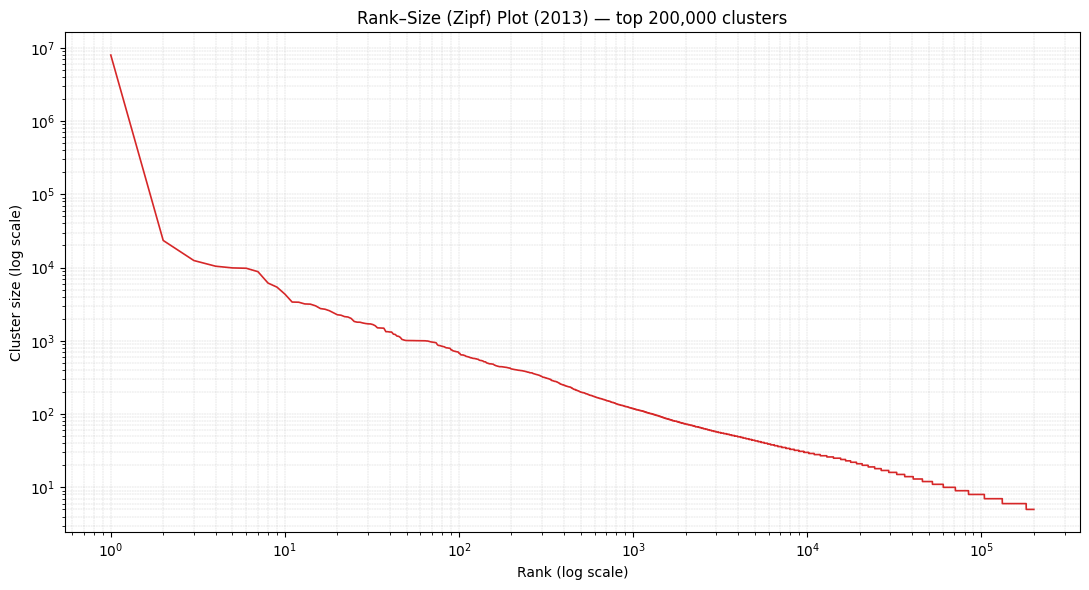

[INFO] Done.


In [ ]:
# -----------------------------
# Paths / config
# -----------------------------
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

patterns = {
    "io": str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}

pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

io_paths = sorted(glob.glob(patterns["io"]))
print("Parquet file counts:", {"io": len(io_paths)})

# -----------------------------
# Analysis window: single year
# -----------------------------
ANALYSIS_YEAR = 2013
ANALYSIS_START = date(ANALYSIS_YEAR, 1, 1)
ANALYSIS_END = date(ANALYSIS_YEAR + 1, 1, 1)  # exclusive
print(f"[INFO] Analysis window: {ANALYSIS_START} .. {ANALYSIS_END} (exclusive)")

# OPTIONAL: preload outputs before year start so early-year spends resolve.
OUTPOINT_DB_LOOKBACK_DAYS = 365
INDEX_START = ANALYSIS_START - timedelta(days=OUTPOINT_DB_LOOKBACK_DAYS)
print(f"[INFO] Outpoint DB preload start: {INDEX_START} .. {ANALYSIS_END} (exclusive)")

# Whether to create UF nodes for every output address (creates a huge singleton universe).
# Keep False for most runs; set True only if you explicitly want *all* output addresses mapped.
PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS = False

# SQLite outpoint index
OUTPOINT_DB_PATH = OUTPUT_DIR / f"outpoints_{ANALYSIS_YEAR}.sqlite"
RESET_OUTPOINT_DB = True  # set False to reuse DB

# Output mapping file (address -> entity_id)
WRITE_ENTITY_MAPPING = True
ENTITY_MAP_OUT_PATH = OUTPUT_DIR / f"entities_multiinput_change_{ANALYSIS_YEAR}.parquet"
ENTITY_MAP_COMPRESSION = "zstd"
ENTITY_WRITE_BATCH = 1_000_000

# Plot controls (your newer plotting)
ZIPF_TOP_K = 200_000
FOCUS_MAX_SIZE = 2048
LOG_BINS = 40

# Print controls (top clusters)
TOP_K_CLUSTERS = 30

# Extra cluster stats / bucket summaries (from your “stats version”)
LOG_BUCKET_BASE = 2  # log-bucket summary base (2 => powers-of-two buckets)


# -----------------------------
# Helpers
# -----------------------------
def extract_day_from_path(path: str) -> date | None:
    """
    Given a path like /.../io/day=2013-05-01/io-0001.parquet
    return date(2013, 5, 1).
    """
    p = Path(path)
    for part in p.parts:
        if part.startswith("day="):
            day_str = part.split("=", 1)[1]
            try:
                return date.fromisoformat(day_str)
            except ValueError:
                return None
    return None


class UnionFind:
    def __init__(self):
        self.parent: list[int] = []
        self.rank: list[int] = []

    def make_set(self) -> int:
        idx = len(self.parent)
        self.parent.append(idx)
        self.rank.append(0)
        return idx

    def find(self, x: int) -> int:
        parent = self.parent
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(self, x: int, y: int) -> None:
        rx = self.find(x)
        ry = self.find(y)
        if rx == ry:
            return

        parent = self.parent
        rank = self.rank

        if rank[rx] < rank[ry]:
            parent[rx] = ry
        elif rank[rx] > rank[ry]:
            parent[ry] = rx
        else:
            parent[ry] = rx
            rank[rx] += 1


def addr_type(addr: str) -> str:
    """Rough address type from prefix (legacy P2PKH, P2SH, Bech32, Taproot, etc.)."""
    if addr.startswith("1"):
        return "p2pkh"
    if addr.startswith("3"):
        return "p2sh"
    if addr.startswith("bc1q"):
        return "bech32_p2wpkh"
    if addr.startswith("bc1p"):
        return "taproot"
    return "other"


def detect_coinjoin_like(n_in_utxos: int, out_values: list[float]) -> bool:
    """
    Very simple CoinJoin-ish heuristic:
    - at least 3 inputs (UTXOs)
    - at least 3 outputs
    - at least 3 outputs with exactly the same value
    """
    n_out = len(out_values)
    if n_in_utxos < 3 or n_out < 3:
        return False
    cnt = Counter(out_values)
    return max(cnt.values()) >= 3


# -----------------------------
# SQLite outpoint DB
# -----------------------------
def open_outpoint_db(db_path: Path, reset: bool) -> sqlite3.Connection:
    if reset and db_path.exists():
        db_path.unlink()

    conn = sqlite3.connect(str(db_path))
    cur = conn.cursor()

    # Speed-oriented pragmas (OK for local reproducible indexing)
    cur.execute("PRAGMA journal_mode=WAL;")
    cur.execute("PRAGMA synchronous=OFF;")
    cur.execute("PRAGMA temp_store=MEMORY;")
    cur.execute("PRAGMA cache_size=-2000000;")  # ~2GB cache (negative => KB)

    cur.execute(
        """
        CREATE TABLE IF NOT EXISTS outpoints (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL,
            address TEXT NOT NULL,
            PRIMARY KEY(txid, n)
        );
        """
    )
    conn.commit()
    return conn


def insert_outpoints(conn: sqlite3.Connection, rows: list[tuple[str, int, str]]) -> None:
    if not rows:
        return
    conn.executemany(
        "INSERT OR IGNORE INTO outpoints(txid, n, address) VALUES (?, ?, ?);",
        rows,
    )
    conn.commit()


def lookup_outpoints(
    conn: sqlite3.Connection,
    keys: list[tuple[str, int]],
    chunk_size: int = 500,
) -> dict[tuple[str, int], str]:
    """
    Lookup many (prev_txid, prev_vout_int) -> address.
    Returns only hits.

    Implemented as chunked OR-clauses to reduce per-row SELECT overhead.
    """
    if not keys:
        return {}

    # Dedup to reduce query work
    keys = list(dict.fromkeys(keys))

    cur = conn.cursor()
    out: dict[tuple[str, int], str] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i:i + chunk_size]
        where = " OR ".join(["(txid=? AND n=?)"] * len(chunk))
        params = [p for k in chunk for p in k]

        cur.execute(f"SELECT txid, n, address FROM outpoints WHERE {where};", params)
        for txid, n, address in cur.fetchall():
            out[(txid, int(n))] = address

    return out


# -----------------------------
# Cluster stats / prints (merged in)
# -----------------------------
def print_top_clusters_from_counts(counts: np.ndarray, n_nodes: int, top_k: int = 20) -> None:
    """
    Prints top clusters by size using counts[eid] where eid is entity_id.
    """
    if counts.size == 0:
        print("[CLUSTERS] No clusters (empty counts).")
        return

    top_k = min(top_k, counts.size)
    top_ids = np.argpartition(counts, -top_k)[-top_k:]
    top_ids_sorted = top_ids[np.argsort(counts[top_ids])[::-1]]

    print(f"\n[CLUSTERS] Top {top_k} clusters by size:")
    for rank, eid in enumerate(top_ids_sorted, start=1):
        sz = int(counts[eid])
        frac = (sz / n_nodes) if n_nodes else float("nan")
        print(f"  #{rank:02d}  entity_id={int(eid):>8d}  size={sz:>12,d}  frac={frac:>7.2%}")

    largest_eid = int(top_ids_sorted[0])
    largest_size = int(counts[largest_eid])
    frac = (largest_size / n_nodes) if n_nodes else float("nan")
    print(f"\n[CLUSTERS] Largest cluster: entity_id={largest_eid} size={largest_size:,} ({frac:.2%} of nodes)")


def print_log_bucket_summary_np(cluster_sizes: np.ndarray, base: int = 2, max_lines: int = 30) -> None:
    """
    Prints a log-bucket summary (counts of entities) based on cluster sizes.
    Bucket k means sizes in (base^(k-1)+1 .. base^k], with k=0 meaning size==1.
    """
    if cluster_sizes.size == 0:
        print("[CLUSTERS] Empty cluster_sizes.")
        return

    buckets = Counter()
    for s in cluster_sizes.tolist():
        s = int(s)
        if s <= 1:
            k = 0
        else:
            # ceil(log_base(s))
            k = int(math.ceil(math.log(s, base)))
        buckets[k] += 1

    print("\n[CLUSTERS] Log-bucket summary (counts of entities):")
    keys = sorted(buckets)
    if len(keys) <= max_lines:
        keys_to_print = keys
    else:
        head = keys[:20]
        tail = keys[-5:]
        keys_to_print = head + [None] + tail

    for k in keys_to_print:
        if k is None:
            print("  ...")
            continue
        lo = 1 if k == 0 else (base ** (k - 1) + 1)
        hi = base ** k
        print(f"  size {lo:>10d} .. {hi:<10d} : {buckets[k]:>12d}")


def print_general_cluster_stats(cluster_sizes: np.ndarray, n_nodes: int) -> None:
    """
    Prints additional general stats about clusters:
      - count of entities
      - largest cluster fraction
      - quantiles
      - counts of singletons / >=10, >=100, >=1k, >=10k, >=100k
    """
    if cluster_sizes.size == 0:
        print("[CLUSTER STATS] Empty cluster_sizes.")
        return

    n_entities = int(cluster_sizes.size)
    largest = int(cluster_sizes.max())
    frac = (largest / n_nodes) if n_nodes else float("nan")

    q = np.quantile(cluster_sizes, [0.5, 0.9, 0.99, 0.999])
    q50, q90, q99, q999 = (int(x) for x in q)

    n_singletons = int((cluster_sizes == 1).sum())
    n_ge_10 = int((cluster_sizes >= 10).sum())
    n_ge_100 = int((cluster_sizes >= 100).sum())
    n_ge_1k = int((cluster_sizes >= 1_000).sum())
    n_ge_10k = int((cluster_sizes >= 10_000).sum())
    n_ge_100k = int((cluster_sizes >= 100_000).sum())

    print("\n[CLUSTER STATS]")
    print(f"  Entities: {n_entities:,}")
    print(f"  UF nodes:  {n_nodes:,}")
    print(f"  Largest cluster size: {largest:,}")
    print(f"  Largest cluster fraction of nodes: {frac:.2%}")
    print(f"  Quantiles: median={q50}  p90={q90}  p99={q99}  p99.9={q999}")
    print(f"  Singletons (size=1): {n_singletons:,}  ({(n_singletons/n_entities):.2%} of entities)")
    print(f"  Entities size>=10:     {n_ge_10:,}")
    print(f"  Entities size>=100:    {n_ge_100:,}")
    print(f"  Entities size>=1,000:  {n_ge_1k:,}")
    print(f"  Entities size>=10,000: {n_ge_10k:,}")
    print(f"  Entities size>=100,000:{n_ge_100k:,}")


# -----------------------------
# Plot helpers (your newer plotting)
# -----------------------------
def _log_bins(max_val: int, bins: int) -> np.ndarray:
    max_val = max(1, int(max_val))
    return np.logspace(0, math.log10(max_val), num=bins)


def plot_hist_logbins(
    sizes: np.ndarray,
    title: str,
    color: str,
    bins: int = LOG_BINS,
    max_x: int | None = None,
) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}")
        return

    if max_x is None:
        max_x = int(sizes.max())

    b = _log_bins(max_x, bins)
    plt.figure(figsize=(11, 6))
    plt.hist(
        sizes,
        bins=b,
        log=True,
        color=color,
        edgecolor="black",
        linewidth=0.6,
    )
    plt.xscale("log")
    plt.xlabel("Cluster size (addresses per entity)")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


def plot_zipf(
    sizes: np.ndarray,
    title: str,
    color: str,
    top_k: int = ZIPF_TOP_K,
) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}")
        return

    top_k = min(top_k, sizes.size)

    # Take top_k largest without sorting all
    top = np.partition(sizes, -top_k)[-top_k:]
    top_sorted = np.sort(top)[::-1]  # descending
    ranks = np.arange(1, top_sorted.size + 1)

    plt.figure(figsize=(11, 6))
    plt.plot(ranks, top_sorted, color=color, linewidth=1.2)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Rank (log scale)")
    plt.ylabel("Cluster size (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


# -----------------------------
# Init structures
# -----------------------------
print(f"Found {len(io_paths)} io parquet files (all years).")

conn = open_outpoint_db(OUTPOINT_DB_PATH, RESET_OUTPOINT_DB)
print(f"[INFO] Outpoint DB: {OUTPOINT_DB_PATH} (reset={RESET_OUTPOINT_DB})")

uf = UnionFind()
addr_to_id: dict[str, int] = {}

# Flags indexed by node_id:
# seen_output_flags[i] == 1 if address i was ever seen as an output
# multi_change_flags[i] bit 0 -> multi-input, bit 1 -> change
seen_output_flags = bytearray()
multi_change_flags = bytearray()

# If we are NOT precreating nodes for all outputs, track seen outputs in a Python set instead
seen_output_addrs: set[str] | None = None
if not PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
    seen_output_addrs = set()

# Stats
n_files_indexed = 0
n_files_analyzed = 0

n_txs_total = 0
n_txs_with_multiinput = 0
n_txs_coinjoin_flagged = 0
n_txs_with_change_detected = 0

n_prevout_lookups = 0
n_prevout_hits = 0


def ensure_flag_capacity(idx: int) -> None:
    needed = idx + 1
    cur = len(seen_output_flags)
    if cur < needed:
        delta = needed - cur
        seen_output_flags.extend(b"\x00" * delta)
        multi_change_flags.extend(b"\x00" * delta)


def get_addr_id(addr: str) -> int:
    idx = addr_to_id.get(addr)
    if idx is None:
        idx = uf.make_set()
        addr_to_id[addr] = idx
        ensure_flag_capacity(idx)
    return idx


# -----------------------------
# Main loop
# -----------------------------
for path in io_paths:
    file_day = extract_day_from_path(path)
    if file_day is None:
        continue

    # Build outpoint DB for [INDEX_START, ANALYSIS_END)
    # Run heuristics only for [ANALYSIS_START, ANALYSIS_END)
    if file_day < INDEX_START or file_day >= ANALYSIS_END:
        continue

    in_analysis = (ANALYSIS_START <= file_day < ANALYSIS_END)

    if in_analysis:
        n_files_analyzed += 1
        if n_files_analyzed <= 5:
            print(f"[{n_files_analyzed}] Processing {path} (day={file_day}) ...")
        elif (n_files_analyzed % 250) == 0:
            print(f"[{n_files_analyzed}] Processing ... (day={file_day})")
    else:
        n_files_indexed += 1
        if n_files_indexed <= 3:
            print(f"[preload {n_files_indexed}] Indexing outputs only: {path} (day={file_day}) ...")

    df = pl.read_parquet(
        path,
        columns=["dir", "txid", "n", "prev_txid", "prev_vout", "address", "value"],
    )

    # Normalize dir
    df = df.with_columns(pl.col("dir").cast(pl.Utf8).str.to_lowercase().alias("dir"))

    # Debug dir values for first analyzed file
    if in_analysis and n_files_analyzed == 1:
        dir_uniques = df.select(pl.col("dir").unique()).to_series().to_list()
        print(f"  [debug] distinct dir values in first processed file: {dir_uniques}")

    # -------------------------
    # 1) Index OUTPUTS (dir == "out") into outpoint DB
    # -------------------------
    out_df = (
        df.filter(pl.col("dir") == "out")
          .filter(pl.col("txid").is_not_null())
          .filter(pl.col("n").is_not_null())
          .filter(pl.col("address").is_not_null())
          .select(
              pl.col("txid"),
              pl.col("n").cast(pl.Int64, strict=False).alias("n"),
              pl.col("address"),
              pl.col("value").cast(pl.Float64, strict=False).alias("value"),
          )
    )

    if out_df.height > 0:
        rows = [(r[0], int(r[1]), r[2]) for r in out_df.select(["txid", "n", "address"]).iter_rows()]
        insert_outpoints(conn, rows)

        if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
            for addr in out_df.select(pl.col("address").unique()).to_series().to_list():
                _ = get_addr_id(addr)

    if not in_analysis:
        # preload-only: done with this file
        del df, out_df
        gc.collect()
        continue

    # -------------------------
    # 2) Resolve INPUT addresses via prev outpoints
    # -------------------------
    in_df = (
        df.filter(pl.col("dir") == "in")
          .filter(pl.col("txid").is_not_null())
          .filter(pl.col("prev_txid").is_not_null())
          .filter(pl.col("prev_vout").is_not_null())
          .select(
              pl.col("txid").alias("spend_txid"),
              pl.col("prev_txid"),
              pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_n"),
          )
          .filter(pl.col("prev_n").is_not_null())
    )

    # Free df early
    del df
    gc.collect()

    input_utxo_count: dict[str, int] = defaultdict(int)
    needed_keys: list[tuple[str, int]] = []
    spend_rows: list[tuple[str, str, int]] = []

    if in_df.height > 0:
        for spend_txid, prev_txid, prev_n in in_df.iter_rows():
            prev_n_int = int(prev_n)
            input_utxo_count[spend_txid] += 1
            needed_keys.append((prev_txid, prev_n_int))
            spend_rows.append((spend_txid, prev_txid, prev_n_int))

    # Safe to delete in_df now (prevents your earlier NameError situation)
    del in_df
    gc.collect()

    n_prevout_lookups += len(needed_keys)
    prevout_map = lookup_outpoints(conn, needed_keys)
    n_prevout_hits += len(prevout_map)

    inputs_by_txid: dict[str, set[str]] = defaultdict(set)
    for spend_txid, prev_txid, prev_n_int in spend_rows:
        addr = prevout_map.get((prev_txid, prev_n_int))
        if addr:
            inputs_by_txid[spend_txid].add(addr)

    # -------------------------
    # 3) Group outputs per tx and run heuristics
    # -------------------------
    if out_df.height == 0:
        del out_df, inputs_by_txid, input_utxo_count, prevout_map, needed_keys, spend_rows
        gc.collect()
        continue

    vout_grouped = (
        out_df.group_by("txid")
              .agg(
                  pl.col("address").alias("out_addrs"),
                  pl.col("value").alias("out_values"),
              )
    )

    del out_df
    gc.collect()

    if vout_grouped.height == 0:
        del vout_grouped, inputs_by_txid, input_utxo_count, prevout_map, needed_keys, spend_rows
        gc.collect()
        continue

    for row in vout_grouped.iter_rows(named=True):
        txid: str = row["txid"]
        out_addrs: list[str] = row["out_addrs"]
        out_values: list[float] = row["out_values"]

        if not out_addrs:
            continue

        n_in_utxos = input_utxo_count.get(txid, 0)
        if n_in_utxos == 0:
            # No input outpoints in this file / none resolved
            continue

        n_txs_total += 1

        # CoinJoin-like check: based on input UTXO count + output values
        if detect_coinjoin_like(n_in_utxos, out_values):
            n_txs_coinjoin_flagged += 1
            # mark outputs seen
            if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                for a in out_addrs:
                    if a is None:
                        continue
                    a_id = get_addr_id(a)
                    seen_output_flags[a_id] = 1
            else:
                for a in out_addrs:
                    if a is not None:
                        seen_output_addrs.add(a)
            continue

        in_addrs_set = inputs_by_txid.get(txid)
        if not in_addrs_set:
            # Inputs exist but none resolved
            if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                for a in out_addrs:
                    if a is None:
                        continue
                    a_id = get_addr_id(a)
                    seen_output_flags[a_id] = 1
            else:
                for a in out_addrs:
                    if a is not None:
                        seen_output_addrs.add(a)
            continue

        in_addrs = list(in_addrs_set)
        n_out = len(out_addrs)

        # --- Multi-input heuristic (UTXO count threshold) ---
        if n_in_utxos >= 2:
            n_txs_with_multiinput += 1
            if len(in_addrs) >= 2:
                in_ids = [get_addr_id(a) for a in in_addrs]
                for idx in in_ids:
                    multi_change_flags[idx] |= 1
                first_id = in_ids[0]
                for idx in in_ids[1:]:
                    uf.union(first_id, idx)
            else:
                idx = get_addr_id(in_addrs[0])
                multi_change_flags[idx] |= 1

        # --- Change heuristic ---
        if n_in_utxos >= 1 and n_out >= 2 and in_addrs:
            in_types = [addr_type(a) for a in in_addrs]
            type_counts = Counter(in_types)
            majority_type = max(type_counts, key=type_counts.get)

            candidates: list[str] = []
            in_addr_set_fast = set(in_addrs)

            for a in out_addrs:
                if a is None:
                    continue
                if a in in_addr_set_fast:
                    continue
                if addr_type(a) != majority_type:
                    continue

                # "New output address" test
                if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                    a_id = get_addr_id(a)
                    if seen_output_flags[a_id]:
                        continue
                else:
                    if a in seen_output_addrs:
                        continue

                candidates.append(a)

            if len(candidates) == 1:
                change_addr = candidates[0]
                change_id = get_addr_id(change_addr)
                multi_change_flags[change_id] |= 2
                n_txs_with_change_detected += 1

                first_input_id = get_addr_id(in_addrs[0])
                uf.union(first_input_id, change_id)

        # mark outputs as seen
        if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
            for a in out_addrs:
                if a is None:
                    continue
                a_id = get_addr_id(a)
                seen_output_flags[a_id] = 1
        else:
            for a in out_addrs:
                if a is not None:
                    seen_output_addrs.add(a)

    del vout_grouped, inputs_by_txid, input_utxo_count, prevout_map, needed_keys, spend_rows
    gc.collect()


# -----------------------------
# Finalize entity mapping + stats
# -----------------------------
print("\nFinalizing entity mapping (compressing components)...")

n_nodes = len(addr_to_id)
print(f"Number of unique addresses with UF nodes: {n_nodes:,}")
hit_rate = (n_prevout_hits / max(1, n_prevout_lookups))
print(f"[INFO] prevout lookups: {n_prevout_lookups:,}  hits: {n_prevout_hits:,}  hit-rate: {hit_rate:.3%}")

if n_nodes == 0:
    print("No union-find nodes created. This means no input addresses were resolved (or heuristics never triggered).")
    conn.close()
    raise SystemExit(0)

# Map UF roots to contiguous entity_ids
node_to_entity = np.empty(n_nodes, dtype=np.int32)
root_to_entity: dict[int, int] = {}
next_entity_id = 0

for node in range(n_nodes):
    root = uf.find(node)
    ent = root_to_entity.get(root)
    if ent is None:
        ent = next_entity_id
        root_to_entity[root] = ent
        next_entity_id += 1
    node_to_entity[node] = ent

n_entities = next_entity_id
print(f"Number of entities (clusters): {n_entities:,}")

# Cluster sizes via bincount (fast + low overhead)
counts = np.bincount(node_to_entity, minlength=n_entities).astype(np.int64)
cluster_sizes = counts[counts > 0]  # length = n_entities

# -----------------------------
# Additional cluster printouts (merged in)
# -----------------------------
print_general_cluster_stats(cluster_sizes, n_nodes=n_nodes)
print_top_clusters_from_counts(counts, n_nodes=n_nodes, top_k=TOP_K_CLUSTERS)
print_log_bucket_summary_np(cluster_sizes, base=LOG_BUCKET_BASE)

# Heuristic flags coverage (node-level)
flags_view = multi_change_flags[:n_nodes]
n_addrs_multi = sum(1 for v in flags_view if (v & 1))
n_addrs_change = sum(1 for v in flags_view if (v & 2))
n_addrs_touched = sum(1 for v in flags_view if (v & 3))

print("\n[HEURISTIC COVERAGE (node-level)]")
print(f"  Total txs processed (outputs + >=1 input UTXO): {n_txs_total:,}")
print(f"  CoinJoin-like skipped: {n_txs_coinjoin_flagged:,}")
print(f"  Multi-input txs (>=2 input UTXOs): {n_txs_with_multiinput:,}")
print(f"  Change detected: {n_txs_with_change_detected:,}")
print(f"  Nodes marked multi-input: {n_addrs_multi:,}")
print(f"  Nodes marked change: {n_addrs_change:,}")
print(f"  Nodes touched by any heuristic: {n_addrs_touched:,}")


# -----------------------------
# Write address -> entity_id mapping (chunked parquet)
# -----------------------------
if WRITE_ENTITY_MAPPING:
    print(f"\n[WRITE] Writing entity mapping to: {ENTITY_MAP_OUT_PATH}")
    if ENTITY_MAP_OUT_PATH.exists():
        ENTITY_MAP_OUT_PATH.unlink()

    writer: pq.ParquetWriter | None = None
    batch_addrs: list[str] = []
    batch_eids: list[int] = []

    written = 0
    for addr, node_id in addr_to_id.items():
        batch_addrs.append(addr)
        batch_eids.append(int(node_to_entity[node_id]))

        if len(batch_addrs) >= ENTITY_WRITE_BATCH:
            table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
            if writer is None:
                writer = pq.ParquetWriter(
                    str(ENTITY_MAP_OUT_PATH),
                    table.schema,
                    compression=ENTITY_MAP_COMPRESSION,
                    use_dictionary=True,
                )
            writer.write_table(table)
            written += len(batch_addrs)
            batch_addrs.clear()
            batch_eids.clear()
            print(f"  [WRITE] rows written: {written:,}")

    if batch_addrs:
        table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
        if writer is None:
            writer = pq.ParquetWriter(
                str(ENTITY_MAP_OUT_PATH),
                table.schema,
                compression=ENTITY_MAP_COMPRESSION,
                use_dictionary=True,
            )
        writer.write_table(table)
        written += len(batch_addrs)
        print(f"  [WRITE] rows written: {written:,}")

    if writer is not None:
        writer.close()

    print("[WRITE] Done.")


# -----------------------------
# Plotting (4 figures)
# -----------------------------
print("\n[PLOT] Generating plots...")

# 1) All clusters, log bins
plot_hist_logbins(
    sizes=cluster_sizes,
    title=f"Entity Cluster Size Distribution ({ANALYSIS_YEAR}) — log bins (all clusters)",
    color="tab:blue",
    bins=LOG_BINS,
)

# 2) Excluding largest cluster (remove just one component; by entity_id is better, but size filter is fine for visuals)
largest = int(cluster_sizes.max()) if cluster_sizes.size else 0
sizes_excl = cluster_sizes[cluster_sizes != largest] if largest > 0 else cluster_sizes
plot_hist_logbins(
    sizes=sizes_excl,
    title=f"Entity Cluster Size Distribution ({ANALYSIS_YEAR}) — excluding largest cluster",
    color="tab:orange",
    bins=LOG_BINS,
)

# 3) Focus window (<= FOCUS_MAX_SIZE)
sizes_focus = cluster_sizes[cluster_sizes <= FOCUS_MAX_SIZE]
plot_hist_logbins(
    sizes=sizes_focus,
    title=f"Entity Cluster Sizes ≤ {FOCUS_MAX_SIZE} ({ANALYSIS_YEAR}) — log bins",
    color="tab:green",
    bins=LOG_BINS,
    max_x=FOCUS_MAX_SIZE,
)

# 4) Zipf plot (rank-size)
plot_zipf(
    sizes=cluster_sizes,
    title=f"Rank–Size (Zipf) Plot ({ANALYSIS_YEAR}) — top {min(ZIPF_TOP_K, cluster_sizes.size):,} clusters",
    color="tab:red",
    top_k=ZIPF_TOP_K,
)

# Close DB
conn.close()
print("[INFO] Done.")


## What “clusters” (entities) mean

A **cluster / entity** is a **connected component** in a graph:

- **Nodes = addresses**
- **Edges = “same controller” links** inferred from transaction patterns

A **cluster size** is simply: **how many addresses became connected** through these inferred links.

---

## Algorithm overview (step-by-step)

### 0) Define two time windows

Two overlapping windows are used:

- **Index window** `[INDEX_START, ANALYSIS_END)`  
  Build an outpoint index so inputs can be resolved to addresses.
- **Analysis window** `[ANALYSIS_START, ANALYSIS_END)`  
  Apply heuristics and add unions (one year of clustering).

Why this is necessary: **Bitcoin inputs do not contain an address**.  
An input only references a previous output (`prev_txid`, `prev_vout`). The address lives in that previous output.

---

### 1) Build an outpoint index (outputs → address)

For each day/file in the **index window**, take rows with `dir == "out"` and store:

- key: `(txid, n)` where `n` is output index (vout)
- value: `address`

This creates a local map: **(prev_txid, prev_vout) → address**, which allows later recovery of input addresses.

---

### 2) Resolve input addresses (prevouts → address)

For each day/file in the **analysis window**, for every row with `dir == "in"`:

- `spend_txid` = spending transaction id
- `(prev_txid, prev_vout)` = the referenced output being spent

Then:

- count total inputs per spending tx: `input_utxo_count[spend_txid] += 1`
- look up `(prev_txid, prev_vout)` in the outpoint index to obtain the **input address**
- group resolved input addresses per spending tx:  
  `inputs_by_txid[spend_txid] = {addr1, addr2, ...}`

Important:
- `input_utxo_count` counts **all inputs** (even unresolved)
- `inputs_by_txid` contains only **resolved input addresses**

---

### 3) Group outputs per transaction

Still within the analysis window, group `dir == "out"` rows by `txid` and collect:

- `out_addrs: [address, ...]`
- `out_values: [value, ...]`

Now each transaction can be analyzed using:
- input UTXO count,
- resolved input addresses,
- output addresses + output amounts.

---

### 4) Per transaction: apply filters + heuristics → add “same owner” edges

For each transaction `txid` that has outputs and at least one input:

#### 4.1 Skip transactions with insufficient structure
- no outputs → skip
- `input_utxo_count[txid] == 0` → skip

#### 4.2 Skip collaborative patterns (CoinJoin-like)
A simple CoinJoin-ish filter flags a transaction if:
- `n_in_utxos >= 3`
- `n_out >= 3`
- at least 3 outputs share exactly the same amount

If flagged:
- **do not add any unions**
- only mark outputs as “seen” (for later “new output” checks)

Goal: avoid linking unrelated participants.

#### 4.3 Multi-input heuristic (high-signal link)
If `n_in_utxos >= 2`:
- take the **resolved unique input addresses** for this tx
- if there are ≥2 distinct resolved input addresses → connect (union) them all
- if only 1 resolved input address → mark it as participating, but no additional links can be created

Interpretation: spending multiple inputs in one transaction usually requires control over all corresponding private keys (or custody over them), so they are treated as belonging to the same entity.

#### 4.4 Change heuristic (riskier link)
Attempt to identify exactly one output that is likely “change” back to the spender:

Candidate output must satisfy all:
- output address is **not** one of the resolved input addresses (not a self-send)
- output address type matches the **majority input type** (prefix-based: `1...`, `3...`, `bc1...`)
- output address is **new as an output** (has not appeared before as an output)

If *exactly one* candidate remains:
- label it as change
- connect (union) it to an input address (e.g., the first resolved input)

Finally:
- mark all outputs as “seen” to support future “new output” tests.

---

### 5) After scanning all files: compress unions → entity IDs → cluster sizes

After processing the entire analysis window:

1) compute each address’s Union-Find root
2) assign a contiguous `entity_id` per root
3) compute cluster sizes (e.g., via `bincount(entity_id)`)
4) report:
   - largest cluster size and fraction
   - top-K cluster sizes
   - quantiles (median/90th/99th)
   - heuristic coverage (how many nodes were linked by which heuristic)
5) optionally write mapping `(address → entity_id)` to Parquet (ideally in chunks)

---

## How to interpret “less permissive union” results

The typical outcome is **heavy-tailed**:

- many clusters of size 1–10
- fewer clusters of size 10–1000
- very few clusters of size 10k+

Sometimes there is a **giant component** (largest cluster far larger than the rest).  
This can be:
- **plausible**: large custodial/service wallets consolidating many deposits
- **a red flag**: false change links “bridge” unrelated clusters, causing cascade merges

Tightening change inference typically causes:
- fewer unions,
- more fragmentation (more clusters),
- reduced dominance of the largest cluster (if change links were the main bridge source).

If the largest cluster stays huge even with strict change rules, it is often driven by multi-input consolidation patterns of large services, or by collaborative transactions not caught by the filter.

Parquet file counts: {'io': 7678}
[INFO] Analysis window: 2013-01-01 .. 2014-01-01 (exclusive)
[INFO] Outpoint DB preload start: 2012-01-02 .. 2014-01-01 (exclusive)
Found 7678 io parquet files (all years).
[INFO] Outpoint DB: /media/vatereal/Main/outputs/outpoints_2013.sqlite (reset=True)
[preload 1] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-02/io-000160190-000160340.parquet (day=2012-01-02) ...
[INFO] Detected value unit: btc  (all internal amount logic uses satoshis)
[preload 2] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-03/io-000160341-000160499.parquet (day=2012-01-03) ...
[preload 3] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-04/io-000160500-000160648.parquet (day=2012-01-04) ...
[1] Processing /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet (day=2013-01-01) ...
  [debug] distinct dir values in first processed file: ['in', 'out']
[2] Processing /media/vatereal/Main/parquet/io/da

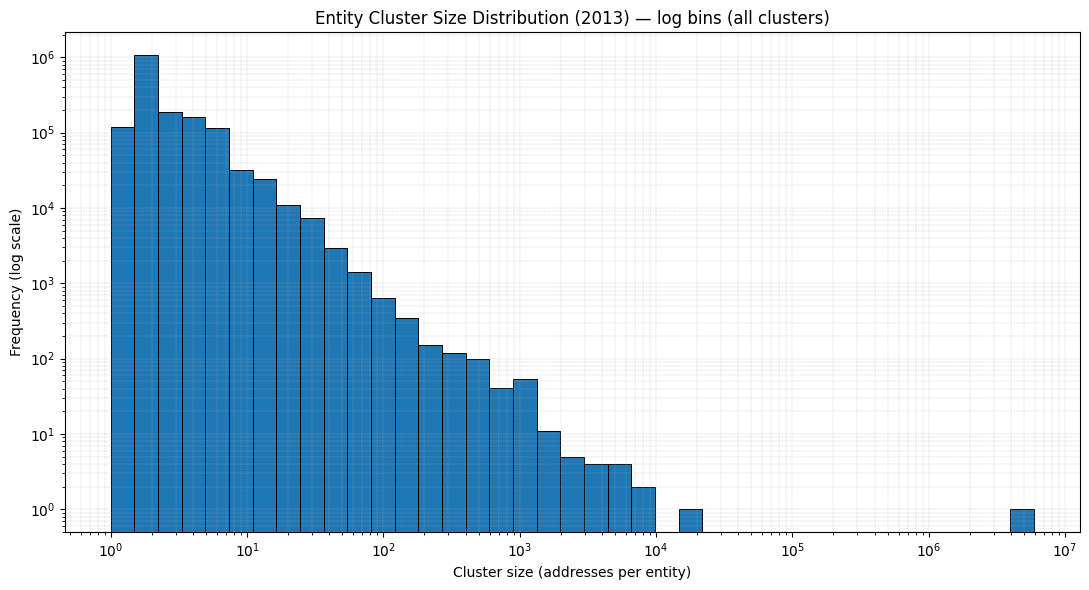

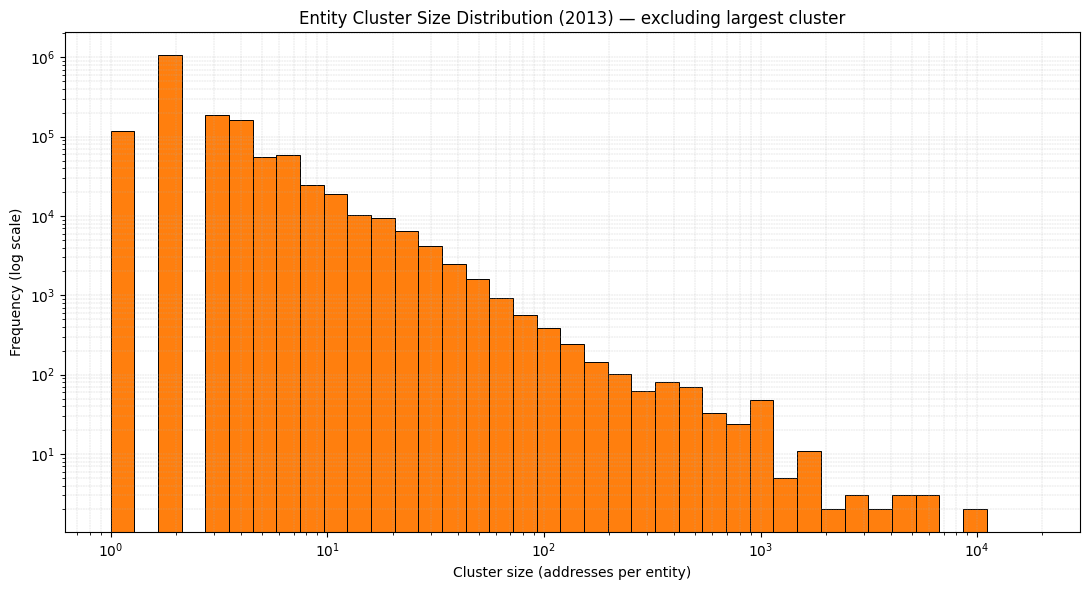

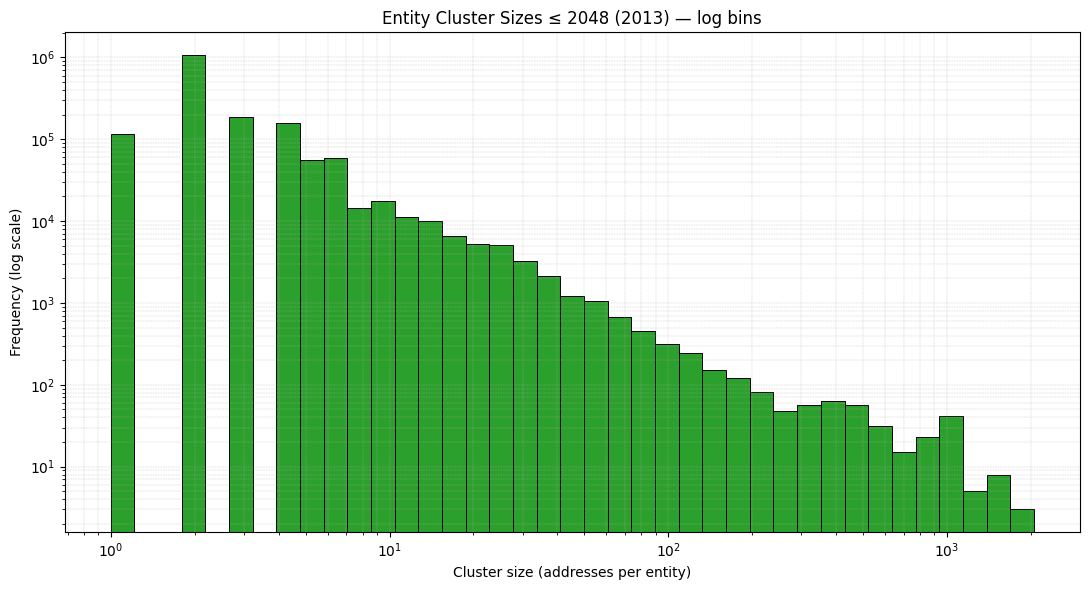

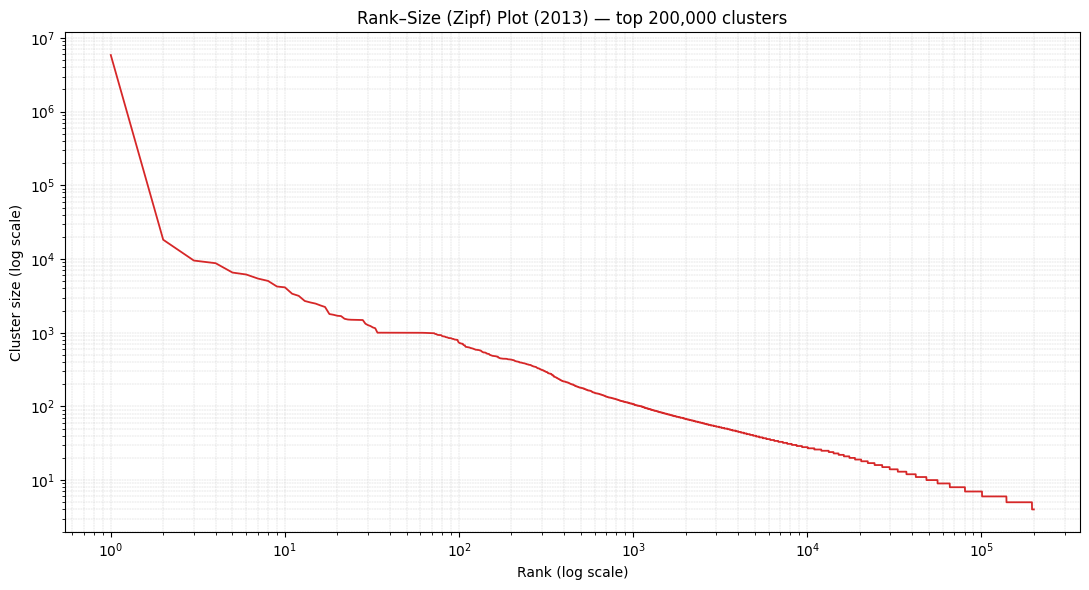

[INFO] Done.


In [3]:
# -----------------------------
# Paths / config
# -----------------------------
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

patterns = {
    "io": str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}

pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

io_paths = sorted(glob.glob(patterns["io"]))
print("Parquet file counts:", {"io": len(io_paths)})

# -----------------------------
# Analysis window: single year
# -----------------------------
ANALYSIS_YEAR = 2013
ANALYSIS_START = date(ANALYSIS_YEAR, 1, 1)
ANALYSIS_END = date(ANALYSIS_YEAR + 1, 1, 1)  # exclusive
print(f"[INFO] Analysis window: {ANALYSIS_START} .. {ANALYSIS_END} (exclusive)")

# OPTIONAL: preload outputs before year start so early-year spends resolve.
OUTPOINT_DB_LOOKBACK_DAYS = 365
INDEX_START = ANALYSIS_START - timedelta(days=OUTPOINT_DB_LOOKBACK_DAYS)
print(f"[INFO] Outpoint DB preload start: {INDEX_START} .. {ANALYSIS_END} (exclusive)")

# Whether to create UF nodes for every output address (creates huge singleton universe).
PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS = False

# SQLite outpoint index
OUTPOINT_DB_PATH = OUTPUT_DIR / f"outpoints_{ANALYSIS_YEAR}.sqlite"
RESET_OUTPOINT_DB = True  # set False to reuse DB

# Output mapping file (address -> entity_id)
WRITE_ENTITY_MAPPING = True
ENTITY_MAP_OUT_PATH = OUTPUT_DIR / f"entities_multiinput_change_{ANALYSIS_YEAR}.parquet"
ENTITY_MAP_COMPRESSION = "zstd"
ENTITY_WRITE_BATCH = 1_000_000

# Plot controls
ZIPF_TOP_K = 200_000
FOCUS_MAX_SIZE = 2048
LOG_BINS = 40

# Print controls
TOP_K_CLUSTERS = 20

# -----------------------------
# Option B: conservative change union controls
# -----------------------------
# Dust threshold (satoshis) for “spendable outputs” used in change inference.
# (2013 era: P2PKH dust threshold commonly cited ~546 sats)
DUST_SATS = 546

# Fee sanity bounds (in satoshis, after normalization)
MAX_FEE_ABS_SATS = 50_000_000      # 0.5 BTC (very permissive ceiling; still rejects absurd data)
MAX_FEE_FRAC = 0.05               # fee <= 5% of sum_inputs

# Additional collaboration/complexity guards (skip change union)
MAX_CHANGE_INPUTS_UTXOS = 10       # if inputs are too many, change inference gets risky
MAX_CHANGE_SPENDABLE_OUTS = 3      # we already require 2 or 3 spendable outs, keep explicit


# -----------------------------
# Helpers
# -----------------------------
def extract_day_from_path(path: str) -> date | None:
    p = Path(path)
    for part in p.parts:
        if part.startswith("day="):
            day_str = part.split("=", 1)[1]
            try:
                return date.fromisoformat(day_str)
            except ValueError:
                return None
    return None


class UnionFind:
    def __init__(self):
        self.parent: list[int] = []
        self.rank: list[int] = []

    def make_set(self) -> int:
        idx = len(self.parent)
        self.parent.append(idx)
        self.rank.append(0)
        return idx

    def find(self, x: int) -> int:
        parent = self.parent
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(self, x: int, y: int) -> None:
        rx = self.find(x)
        ry = self.find(y)
        if rx == ry:
            return
        parent = self.parent
        rank = self.rank
        if rank[rx] < rank[ry]:
            parent[rx] = ry
        elif rank[rx] > rank[ry]:
            parent[ry] = rx
        else:
            parent[ry] = rx
            rank[rx] += 1


def addr_type(addr: str) -> str:
    if addr.startswith("1"):
        return "p2pkh"
    if addr.startswith("3"):
        return "p2sh"
    if addr.startswith("bc1q"):
        return "bech32_p2wpkh"
    if addr.startswith("bc1p"):
        return "taproot"
    return "other"


def detect_coinjoin_like_sats(n_in_utxos: int, out_values_sats: list[int]) -> bool:
    """
    Very simple CoinJoin-ish heuristic:
    - at least 3 inputs (UTXOs)
    - at least 3 outputs
    - at least 3 outputs with exactly the same value
    """
    n_out = len(out_values_sats)
    if n_in_utxos < 3 or n_out < 3:
        return False
    cnt = Counter(out_values_sats)
    return max(cnt.values()) >= 3


# -----------------------------
# Value normalization: detect BTC vs sats and convert to sats
# -----------------------------
VALUE_UNIT: str | None = None  # "btc" or "sats"

def infer_value_unit_from_sample(sample_vals: list[float]) -> str:
    """
    Heuristic:
      - If values look like huge integers (>= 1e6), treat as satoshis.
      - Else treat as BTC.
    This works well because BTC amounts rarely exceed 1e6, but satoshi amounts often do.
    """
    if not sample_vals:
        return "btc"
    mx = max(sample_vals)
    return "sats" if mx >= 1e6 else "btc"

def value_expr_to_sats() -> pl.Expr:
    """
    Polars expression that produces Int64 satoshis from 'value' given detected VALUE_UNIT.
    """
    if VALUE_UNIT == "sats":
        return pl.col("value").cast(pl.Float64, strict=False).round(0).cast(pl.Int64, strict=False)
    # default BTC
    return (pl.col("value").cast(pl.Float64, strict=False) * 100_000_000).round(0).cast(pl.Int64, strict=False)


# -----------------------------
# SQLite outpoint DB (stores address + value_sats)
# -----------------------------
def open_outpoint_db(db_path: Path, reset: bool) -> sqlite3.Connection:
    if reset and db_path.exists():
        db_path.unlink()

    conn = sqlite3.connect(str(db_path))
    cur = conn.cursor()

    cur.execute("PRAGMA journal_mode=WAL;")
    cur.execute("PRAGMA synchronous=OFF;")
    cur.execute("PRAGMA temp_store=MEMORY;")
    cur.execute("PRAGMA cache_size=-2000000;")  # ~2GB cache (negative => KB)

    cur.execute(
        """
        CREATE TABLE IF NOT EXISTS outpoints (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL,
            address TEXT NOT NULL,
            value_sats INTEGER NOT NULL,
            PRIMARY KEY(txid, n)
        );
        """
    )
    conn.commit()
    return conn


def insert_outpoints(conn: sqlite3.Connection, rows: list[tuple[str, int, str, int]]) -> None:
    if not rows:
        return
    conn.executemany(
        "INSERT OR IGNORE INTO outpoints(txid, n, address, value_sats) VALUES (?, ?, ?, ?);",
        rows,
    )
    conn.commit()


def lookup_outpoints(
    conn: sqlite3.Connection,
    keys: list[tuple[str, int]],
    chunk_size: int = 500,
) -> dict[tuple[str, int], tuple[str, int]]:
    """
    Lookup many (prev_txid, prev_n) -> (address, value_sats).
    Returns only hits.
    Uses chunked OR-clauses to reduce per-row SELECT overhead.
    """
    if not keys:
        return {}

    # Dedup keys to reduce query work
    keys = list(dict.fromkeys(keys))

    cur = conn.cursor()
    out: dict[tuple[str, int], tuple[str, int]] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i:i + chunk_size]
        where = " OR ".join(["(txid=? AND n=?)"] * len(chunk))
        params = [p for k in chunk for p in k]
        cur.execute(f"SELECT txid, n, address, value_sats FROM outpoints WHERE {where};", params)
        for txid, n, address, value_sats in cur.fetchall():
            out[(txid, int(n))] = (address, int(value_sats))

    return out


# -----------------------------
# Plot helpers
# -----------------------------
def _log_bins(max_val: int, bins: int) -> np.ndarray:
    max_val = max(1, int(max_val))
    return np.logspace(0, math.log10(max_val), num=bins)

def plot_hist_logbins(
    sizes: np.ndarray,
    title: str,
    color: str,
    bins: int = LOG_BINS,
    max_x: int | None = None,
) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}")
        return

    if max_x is None:
        max_x = int(sizes.max())

    b = _log_bins(max_x, bins)
    plt.figure(figsize=(11, 6))
    plt.hist(
        sizes,
        bins=b,
        log=True,
        color=color,
        edgecolor="black",
        linewidth=0.7,
    )
    plt.xscale("log")
    plt.xlabel("Cluster size (addresses per entity)")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_zipf(
    sizes: np.ndarray,
    title: str,
    color: str,
    top_k: int = ZIPF_TOP_K,
) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}")
        return

    top_k = min(top_k, sizes.size)
    top = np.partition(sizes, -top_k)[-top_k:]
    top_sorted = np.sort(top)[::-1]
    ranks = np.arange(1, top_sorted.size + 1)

    plt.figure(figsize=(11, 6))
    plt.plot(ranks, top_sorted, color=color, linewidth=1.3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Rank (log scale)")
    plt.ylabel("Cluster size (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


# -----------------------------
# Init structures
# -----------------------------
print(f"Found {len(io_paths)} io parquet files (all years).")

conn = open_outpoint_db(OUTPOINT_DB_PATH, RESET_OUTPOINT_DB)
print(f"[INFO] Outpoint DB: {OUTPOINT_DB_PATH} (reset={RESET_OUTPOINT_DB})")

uf = UnionFind()
addr_to_id: dict[str, int] = {}

# Flags indexed by node_id:
seen_output_flags = bytearray()
multi_change_flags = bytearray()

seen_output_addrs: set[str] | None = None
if not PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
    seen_output_addrs = set()

# Stats
n_files_indexed = 0
n_files_analyzed = 0

n_txs_total = 0
n_txs_with_multiinput = 0
n_txs_coinjoin_flagged = 0
n_txs_with_change_detected = 0

n_prevout_lookups = 0
n_prevout_hits = 0


def ensure_flag_capacity(idx: int) -> None:
    needed = idx + 1
    cur = len(seen_output_flags)
    if cur < needed:
        delta = needed - cur
        seen_output_flags.extend(b"\x00" * delta)
        multi_change_flags.extend(b"\x00" * delta)

def get_addr_id(addr: str) -> int:
    idx = addr_to_id.get(addr)
    if idx is None:
        idx = uf.make_set()
        addr_to_id[addr] = idx
        ensure_flag_capacity(idx)
    return idx


# -----------------------------
# Main loop
# -----------------------------
for path in io_paths:
    file_day = extract_day_from_path(path)
    if file_day is None:
        continue

    # Build outpoint DB for [INDEX_START, ANALYSIS_END)
    # Run heuristics only for [ANALYSIS_START, ANALYSIS_END)
    if file_day < INDEX_START or file_day >= ANALYSIS_END:
        continue

    in_analysis = (ANALYSIS_START <= file_day < ANALYSIS_END)

    if in_analysis:
        n_files_analyzed += 1
        if n_files_analyzed <= 5:
            print(f"[{n_files_analyzed}] Processing {path} (day={file_day}) ...")
        elif (n_files_analyzed % 250) == 0:
            print(f"[{n_files_analyzed}] Processing ... (day={file_day})")
    else:
        n_files_indexed += 1
        if n_files_indexed <= 3:
            print(f"[preload {n_files_indexed}] Indexing outputs only: {path} (day={file_day}) ...")

    df = pl.read_parquet(
        path,
        columns=["dir", "txid", "n", "prev_txid", "prev_vout", "address", "value"],
    )

    df = df.with_columns(pl.col("dir").cast(pl.Utf8).str.to_lowercase().alias("dir"))

    # Infer value unit once (from outputs sample)
    global VALUE_UNIT
    if VALUE_UNIT is None:
        sample = (
            df.filter(pl.col("dir") == "out")
              .select(pl.col("value").cast(pl.Float64, strict=False))
              .drop_nulls()
              .head(5000)
              .to_series()
              .to_list()
        )
        VALUE_UNIT = infer_value_unit_from_sample(sample)
        print(f"[INFO] Detected value unit: {VALUE_UNIT}  (all internal amount logic uses satoshis)")

    if in_analysis and n_files_analyzed == 1:
        dir_uniques = df.select(pl.col("dir").unique()).to_series().to_list()
        print(f"  [debug] distinct dir values in first processed file: {dir_uniques}")

    # -------------------------
    # 1) Index OUTPUTS into outpoint DB
    # -------------------------
    # Keep ALL outputs (including address null) for shape/fee logic; but DB insert needs address non-null.
    out_all = (
        df.filter(pl.col("dir") == "out")
          .filter(pl.col("txid").is_not_null())
          .filter(pl.col("n").is_not_null())
          .select(
              pl.col("txid"),
              pl.col("n").cast(pl.Int64, strict=False).alias("n"),
              pl.col("address"),
              value_expr_to_sats().alias("value_sats"),
          )
    )

    # Insert only outputs with address (since those map to an address owner)
    out_for_db = out_all.filter(pl.col("address").is_not_null()).filter(pl.col("value_sats").is_not_null())
    if out_for_db.height > 0:
        rows = [
            (r[0], int(r[1]), r[2], int(r[3]))
            for r in out_for_db.select(["txid", "n", "address", "value_sats"]).iter_rows()
        ]
        insert_outpoints(conn, rows)

        if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
            for addr in out_for_db.select(pl.col("address").unique()).to_series().to_list():
                _ = get_addr_id(addr)

    if not in_analysis:
        del df, out_all, out_for_db
        gc.collect()
        continue

    # -------------------------
    # 2) Resolve INPUT addresses via prev outpoints
    # -------------------------
    in_df = (
        df.filter(pl.col("dir") == "in")
          .filter(pl.col("txid").is_not_null())
          .filter(pl.col("prev_txid").is_not_null())
          .filter(pl.col("prev_vout").is_not_null())
          .select(
              pl.col("txid").alias("spend_txid"),
              pl.col("prev_txid"),
              pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_n"),
          )
          .filter(pl.col("prev_n").is_not_null())
    )

    # Free df early
    del df
    gc.collect()

    # Track per-spend tx:
    input_utxo_count: dict[str, int] = defaultdict(int)         # total inputs (UTXOs) observed
    resolved_utxo_count: dict[str, int] = defaultdict(int)      # inputs resolved in outpoint DB
    sum_inputs_sats: dict[str, int] = defaultdict(int)          # sum of resolved input values
    needed_keys: list[tuple[str, int]] = []
    spend_rows: list[tuple[str, str, int]] = []

    if in_df.height > 0:
        for spend_txid, prev_txid, prev_n in in_df.iter_rows():
            prev_n_int = int(prev_n)
            input_utxo_count[spend_txid] += 1
            needed_keys.append((prev_txid, prev_n_int))
            spend_rows.append((spend_txid, prev_txid, prev_n_int))

    del in_df
    gc.collect()

    n_prevout_lookups += len(needed_keys)
    prevout_map = lookup_outpoints(conn, needed_keys)
    n_prevout_hits += len(prevout_map)

    inputs_by_txid: dict[str, set[str]] = defaultdict(set)
    for spend_txid, prev_txid, prev_n_int in spend_rows:
        hit = prevout_map.get((prev_txid, prev_n_int))
        if hit:
            addr, val_sats = hit
            inputs_by_txid[spend_txid].add(addr)
            resolved_utxo_count[spend_txid] += 1
            sum_inputs_sats[spend_txid] += int(val_sats)

    # -------------------------
    # 3) Group outputs per tx and run heuristics
    # -------------------------
    if out_all.height == 0:
        del out_all, out_for_db, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, prevout_map, needed_keys, spend_rows
        gc.collect()
        continue

    # Group ALL outputs for tx-level shape/fee checks
    vout_grouped = (
        out_all.group_by("txid")
               .agg(
                   pl.col("address").alias("out_addrs_all"),
                   pl.col("value_sats").alias("out_values_sats_all"),
               )
    )

    del out_all, out_for_db
    gc.collect()

    if vout_grouped.height == 0:
        del vout_grouped, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, prevout_map, needed_keys, spend_rows
        gc.collect()
        continue

    for row in vout_grouped.iter_rows(named=True):
        txid: str = row["txid"]
        out_addrs_all: list[str | None] = row["out_addrs_all"]
        out_values_all: list[int | None] = row["out_values_sats_all"]

        if not out_addrs_all or not out_values_all:
            continue

        n_in_utxos = input_utxo_count.get(txid, 0)
        if n_in_utxos == 0:
            continue

        n_txs_total += 1

        # Build output tuples, keep total outputs for fee logic
        outputs: list[tuple[str | None, int]] = []
        sum_outputs_sats = 0
        for a, v in zip(out_addrs_all, out_values_all):
            if v is None:
                continue
            vi = int(v)
            outputs.append((a, vi))
            sum_outputs_sats += vi

        # Derive spendable outputs for change inference
        spendable = [(a, v) for (a, v) in outputs if a is not None and v >= DUST_SATS]
        spendable_vals = [v for (_, v) in spendable]

        # Anti-collaboration: CoinJoin-like (use spendable values to avoid OP_RETURN zeros)
        if detect_coinjoin_like_sats(n_in_utxos, spendable_vals):
            n_txs_coinjoin_flagged += 1
            # mark all non-null output addresses as seen
            if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                for a, _v in outputs:
                    if a is None:
                        continue
                    a_id = get_addr_id(a)
                    seen_output_flags[a_id] = 1
            else:
                for a, _v in outputs:
                    if a is not None:
                        seen_output_addrs.add(a)
            continue

        # Inputs resolved?
        in_addrs_set = inputs_by_txid.get(txid)
        if not in_addrs_set:
            # still mark outputs seen
            if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                for a, _v in outputs:
                    if a is None:
                        continue
                    a_id = get_addr_id(a)
                    seen_output_flags[a_id] = 1
            else:
                for a, _v in outputs:
                    if a is not None:
                        seen_output_addrs.add(a)
            continue

        in_addrs = list(in_addrs_set)

        # -------------------------
        # Multi-input heuristic (unchanged)
        # -------------------------
        if n_in_utxos >= 2:
            n_txs_with_multiinput += 1
            if len(in_addrs) >= 2:
                in_ids = [get_addr_id(a) for a in in_addrs]
                for idx in in_ids:
                    multi_change_flags[idx] |= 1
                first_id = in_ids[0]
                for idx in in_ids[1:]:
                    uf.union(first_id, idx)
            else:
                idx = get_addr_id(in_addrs[0])
                multi_change_flags[idx] |= 1

        # -------------------------
        # Option B: Conservative change union
        # -------------------------
        # Gate 0: complexity/collaboration guards
        n_spendable_out = len(spendable)
        if n_in_utxos > MAX_CHANGE_INPUTS_UTXOS:
            pass  # skip change inference
        elif n_spendable_out not in (2, 3):
            pass  # shape constraint
        elif n_spendable_out > MAX_CHANGE_SPENDABLE_OUTS:
            pass
        else:
            # Reject if any non-dust output has NULL address (incomplete output set)
            null_addr_non_dust = any((a is None and v >= DUST_SATS) for (a, v) in outputs)
            if null_addr_non_dust:
                pass
            else:
                # Newness/type/amount logic requires full input resolution
                resolved_cnt = resolved_utxo_count.get(txid, 0)
                if resolved_cnt != n_in_utxos:
                    pass
                else:
                    # Type constraint: require all resolved input types identical (very strict)
                    in_types = [addr_type(a) for a in in_addrs]
                    if len(set(in_types)) != 1:
                        pass
                    else:
                        majority_type = in_types[0]

                        # Output duplicate address guard (if an address appears twice among spendable outs, skip)
                        spendable_addrs = [a for (a, _v) in spendable]  # all non-null by construction
                        if len(spendable_addrs) != len(set(spendable_addrs)):
                            pass
                        else:
                            in_addr_set_fast = set(in_addrs)

                            candidates: list[tuple[str, int]] = []
                            for a, v in spendable:
                                # exclude self-change / returning to input addr
                                if a in in_addr_set_fast:
                                    continue
                                if addr_type(a) != majority_type:
                                    continue

                                # Newness constraint: must be unseen output address so far
                                if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                                    a_id = get_addr_id(a)
                                    if seen_output_flags[a_id]:
                                        continue
                                else:
                                    if a in seen_output_addrs:
                                        continue

                                candidates.append((a, v))

                            # Uniqueness constraint
                            if len(candidates) == 1:
                                change_addr, change_val = candidates[0]

                                # Amount logic: fee sanity + "not payment-looking"
                                sum_in = sum_inputs_sats.get(txid, 0)
                                fee = sum_in - sum_outputs_sats

                                # Fee sanity
                                if sum_in <= 0:
                                    pass
                                elif fee < 0:
                                    pass
                                else:
                                    # fee caps
                                    if fee > MAX_FEE_ABS_SATS:
                                        pass
                                    elif fee > int(MAX_FEE_FRAC * sum_in):
                                        pass
                                    else:
                                        # Payment-looking rule:
                                        # - If 2 spendable outs: change must be the smaller output
                                        # - If 3 spendable outs: change must be the smallest output
                                        spend_vals = [v for (_a, v) in spendable]
                                        if n_spendable_out == 2:
                                            other_val = max(v for (_a, v) in spendable if _a != change_addr)
                                            if not (change_val < other_val):
                                                pass
                                            else:
                                                # UNION
                                                change_id = get_addr_id(change_addr)
                                                multi_change_flags[change_id] |= 2
                                                n_txs_with_change_detected += 1
                                                uf.union(get_addr_id(in_addrs[0]), change_id)
                                        else:
                                            # n_spendable_out == 3
                                            if change_val != min(spend_vals):
                                                pass
                                            else:
                                                change_id = get_addr_id(change_addr)
                                                multi_change_flags[change_id] |= 2
                                                n_txs_with_change_detected += 1
                                                uf.union(get_addr_id(in_addrs[0]), change_id)

        # -------------------------
        # Mark all non-null outputs as seen (for future newness checks)
        # -------------------------
        if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
            for a, _v in outputs:
                if a is None:
                    continue
                a_id = get_addr_id(a)
                seen_output_flags[a_id] = 1
        else:
            for a, _v in outputs:
                if a is not None:
                    seen_output_addrs.add(a)

    del vout_grouped, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, prevout_map, needed_keys, spend_rows
    gc.collect()


# -----------------------------
# Finalize entity mapping + stats
# -----------------------------
print("\nFinalizing entity mapping (compressing components)...")

n_nodes = len(addr_to_id)
print(f"Number of unique addresses with UF nodes: {n_nodes:,}")
hit_rate = (n_prevout_hits / max(1, n_prevout_lookups))
print(f"[INFO] prevout lookups: {n_prevout_lookups:,}  hits: {n_prevout_hits:,}  hit-rate: {hit_rate:.3%}")

if n_nodes == 0:
    print("No union-find nodes created. This means no input addresses were resolved (or heuristics never triggered).")
    conn.close()
    raise SystemExit(0)

# Map UF roots to contiguous entity_ids
node_to_entity = np.empty(n_nodes, dtype=np.int32)
root_to_entity: dict[int, int] = {}
next_entity_id = 0

for node in range(n_nodes):
    root = uf.find(node)
    ent = root_to_entity.get(root)
    if ent is None:
        ent = next_entity_id
        root_to_entity[root] = ent
        next_entity_id += 1
    node_to_entity[node] = ent

n_entities = next_entity_id
print(f"Number of entities (clusters): {n_entities:,}")

# Cluster sizes via bincount
counts = np.bincount(node_to_entity, minlength=n_entities).astype(np.int64)
cluster_sizes = counts[counts > 0]

largest = int(cluster_sizes.max()) if cluster_sizes.size else 0
largest_frac = (largest / n_nodes) if n_nodes else float("nan")

# Top clusters printout
top_k = min(TOP_K_CLUSTERS, n_entities)
top_ids = np.argpartition(counts, -top_k)[-top_k:]
top_ids_sorted = top_ids[np.argsort(counts[top_ids])[::-1]]

print("\n[TOP CLUSTERS]")
for rank, eid in enumerate(top_ids_sorted, start=1):
    sz = int(counts[eid])
    frac = (sz / n_nodes) if n_nodes else float("nan")
    print(f"  #{rank:02d}  entity_id={int(eid):>8d}  size={sz:>10,d}  frac={frac:>7.2%}")

q50, q90, q99 = np.quantile(cluster_sizes, [0.5, 0.9, 0.99])
print("\n[CLUSTER STATS]")
print(f"  Entities: {n_entities:,}")
print(f"  Largest cluster size: {largest:,}")
print(f"  Largest cluster fraction of nodes: {largest_frac:.2%}")
print(f"  Median cluster size: {int(q50)}")
print(f"  90th percentile: {int(q90)}")
print(f"  99th percentile: {int(q99)}")

# Heuristic flags coverage (node-level)
flags_view = multi_change_flags[:n_nodes]
n_addrs_multi = sum(1 for v in flags_view if (v & 1))
n_addrs_change = sum(1 for v in flags_view if (v & 2))
n_addrs_touched = sum(1 for v in flags_view if (v & 3))

print("\n[HEURISTIC COVERAGE (node-level)]")
print(f"  Total txs processed (>=1 input UTXO): {n_txs_total:,}")
print(f"  CoinJoin-like skipped: {n_txs_coinjoin_flagged:,}")
print(f"  Multi-input txs (>=2 input UTXOs): {n_txs_with_multiinput:,}")
print(f"  Change detected + unioned (conservative): {n_txs_with_change_detected:,}")
print(f"  Nodes marked multi-input: {n_addrs_multi:,}")
print(f"  Nodes marked change: {n_addrs_change:,}")
print(f"  Nodes touched by any heuristic: {n_addrs_touched:,}")

# -----------------------------
# Write address -> entity_id mapping (chunked parquet)
# -----------------------------
if WRITE_ENTITY_MAPPING:
    print(f"\n[WRITE] Writing entity mapping to: {ENTITY_MAP_OUT_PATH}")
    if ENTITY_MAP_OUT_PATH.exists():
        ENTITY_MAP_OUT_PATH.unlink()

    writer: pq.ParquetWriter | None = None
    batch_addrs: list[str] = []
    batch_eids: list[int] = []

    written = 0
    for addr, node_id in addr_to_id.items():
        batch_addrs.append(addr)
        batch_eids.append(int(node_to_entity[node_id]))

        if len(batch_addrs) >= ENTITY_WRITE_BATCH:
            table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
            if writer is None:
                writer = pq.ParquetWriter(
                    str(ENTITY_MAP_OUT_PATH),
                    table.schema,
                    compression=ENTITY_MAP_COMPRESSION,
                    use_dictionary=True,
                )
            writer.write_table(table)
            written += len(batch_addrs)
            batch_addrs.clear()
            batch_eids.clear()
            print(f"  [WRITE] rows written: {written:,}")

    if batch_addrs:
        table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
        if writer is None:
            writer = pq.ParquetWriter(
                str(ENTITY_MAP_OUT_PATH),
                table.schema,
                compression=ENTITY_MAP_COMPRESSION,
                use_dictionary=True,
            )
        writer.write_table(table)
        written += len(batch_addrs)
        print(f"  [WRITE] rows written: {written:,}")

    if writer is not None:
        writer.close()

    print("[WRITE] Done.")

# -----------------------------
# Plotting (4 figures)
# -----------------------------
print("\n[PLOT] Generating plots...")

plot_hist_logbins(
    sizes=cluster_sizes,
    title=f"Entity Cluster Size Distribution ({ANALYSIS_YEAR}) — log bins (all clusters)",
    color="tab:blue",
    bins=LOG_BINS,
)

if largest > 0:
    sizes_excl = cluster_sizes[cluster_sizes != largest]
else:
    sizes_excl = cluster_sizes

plot_hist_logbins(
    sizes=sizes_excl,
    title=f"Entity Cluster Size Distribution ({ANALYSIS_YEAR}) — excluding largest cluster",
    color="tab:orange",
    bins=LOG_BINS,
)

sizes_focus = cluster_sizes[cluster_sizes <= FOCUS_MAX_SIZE]
plot_hist_logbins(
    sizes=sizes_focus,
    title=f"Entity Cluster Sizes ≤ {FOCUS_MAX_SIZE} ({ANALYSIS_YEAR}) — log bins",
    color="tab:green",
    bins=LOG_BINS,
    max_x=FOCUS_MAX_SIZE,
)

plot_zipf(
    sizes=cluster_sizes,
    title=f"Rank–Size (Zipf) Plot ({ANALYSIS_YEAR}) — top {min(ZIPF_TOP_K, cluster_sizes.size):,} clusters",
    color="tab:red",
    top_k=ZIPF_TOP_K,
)

conn.close()
print("[INFO] Done.")

Parquet file counts: {'io': 7678}
[INFO] Analysis window: 2013-01-01 .. 2014-01-01 (exclusive)
[INFO] Outpoint DB preload start: 2012-01-02 .. 2014-01-01 (exclusive)
Found 7678 io parquet files (all years).
[INFO] Outpoint DB: /media/vatereal/Main/outputs/outpoints_2013.sqlite (reset=True)
[INFO] Eligible files in window: 753  (preload=375, analysis=378)


Processing parquet:   0%|          | 0/753 [00:00<?, ?file/s]

[preload 1] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-02/io-000160190-000160340.parquet (day=2012-01-02) ...
[INFO] Detected value unit: btc  (all internal amount logic uses satoshis)
[preload 2] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-03/io-000160341-000160499.parquet (day=2012-01-03) ...
[preload 3] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-04/io-000160500-000160648.parquet (day=2012-01-04) ...
[1] Processing /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet (day=2013-01-01) ...
[2] Processing /media/vatereal/Main/parquet/io/day=2013-01-02/io-000214725-000214877.parquet (day=2013-01-02) ...
[3] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000214878-000215032.parquet (day=2013-01-03) ...
[4] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000215033-000215039.parquet (day=2013-01-03) ...
[5] Processing /media/vatereal/Main/parquet/io/day=2013-01-04/io-00

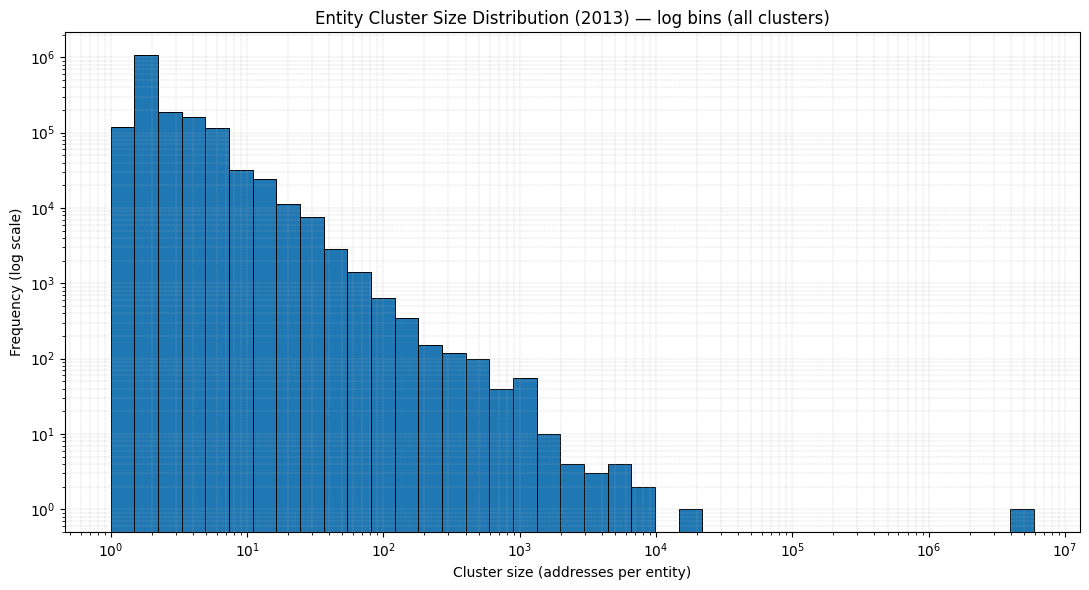

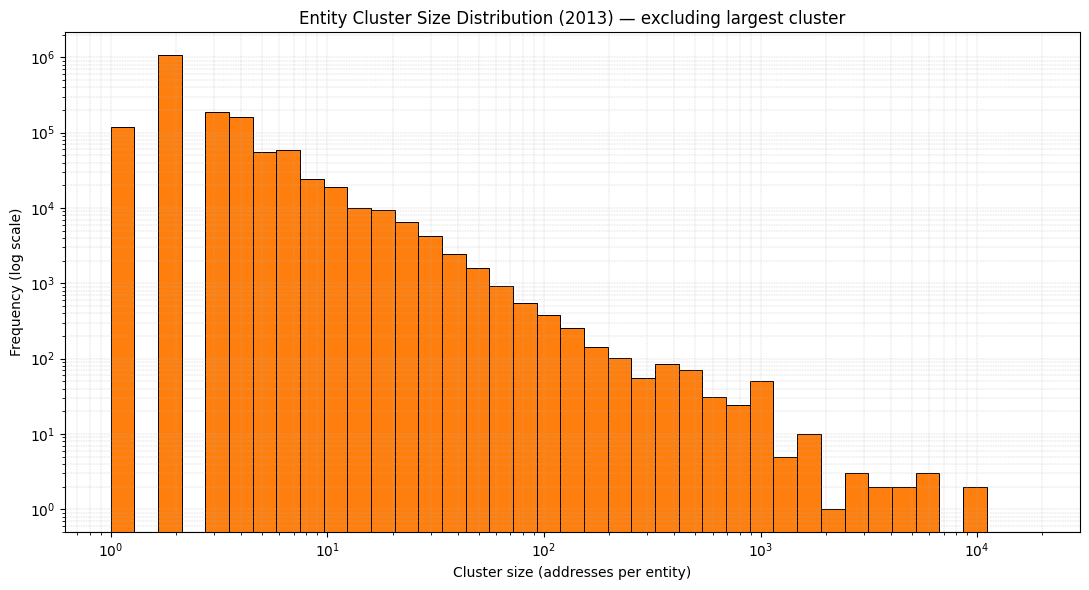

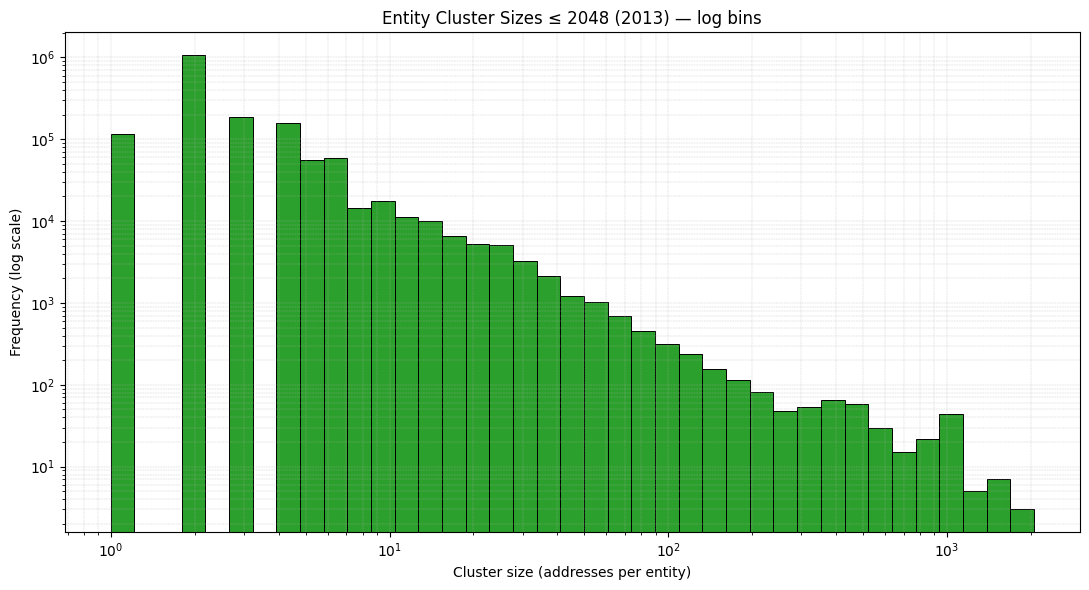

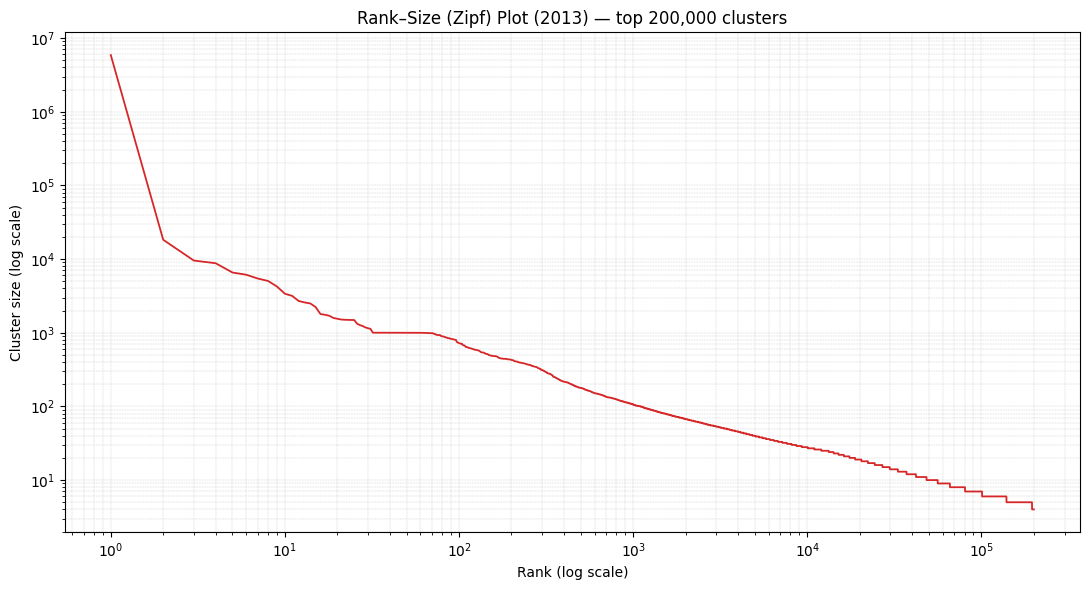

[INFO] Done.


In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from __future__ import annotations

import gc
import glob
import math
import sqlite3
from collections import Counter, defaultdict
from datetime import date, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm.auto import tqdm


# -----------------------------
# Paths / config
# -----------------------------
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

patterns = {
    "io": str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}

pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

io_paths = sorted(glob.glob(patterns["io"]))
print("Parquet file counts:", {"io": len(io_paths)})

# -----------------------------
# Analysis window: single year
# -----------------------------
ANALYSIS_YEAR = 2013
ANALYSIS_START = date(ANALYSIS_YEAR, 1, 1)
ANALYSIS_END = date(ANALYSIS_YEAR + 1, 1, 1)  # exclusive
print(f"[INFO] Analysis window: {ANALYSIS_START} .. {ANALYSIS_END} (exclusive)")

# OPTIONAL: preload outputs before year start so early-year spends resolve.
OUTPOINT_DB_LOOKBACK_DAYS = 365
INDEX_START = ANALYSIS_START - timedelta(days=OUTPOINT_DB_LOOKBACK_DAYS)
print(f"[INFO] Outpoint DB preload start: {INDEX_START} .. {ANALYSIS_END} (exclusive)")

# Whether to create UF nodes for every output address (creates huge singleton universe).
PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS = False

# SQLite outpoint index
OUTPOINT_DB_PATH = OUTPUT_DIR / f"outpoints_{ANALYSIS_YEAR}.sqlite"
RESET_OUTPOINT_DB = True  # set False to reuse DB

# Output mapping file (address -> entity_id)
WRITE_ENTITY_MAPPING = True
ENTITY_MAP_OUT_PATH = OUTPUT_DIR / f"entities_multiinput_change_{ANALYSIS_YEAR}.parquet"
ENTITY_MAP_COMPRESSION = "zstd"
ENTITY_WRITE_BATCH = 1_000_000

# Plot controls
ZIPF_TOP_K = 200_000
FOCUS_MAX_SIZE = 2048
LOG_BINS = 40

# Print controls
TOP_K_CLUSTERS = 20

# -----------------------------
# Option B: conservative change union controls
# -----------------------------
DUST_SATS = 546

MAX_FEE_ABS_SATS = 50_000_000
MAX_FEE_FRAC = 0.05

MAX_CHANGE_INPUTS_UTXOS = 10
MAX_CHANGE_SPENDABLE_OUTS = 3

# -----------------------------
# Performance knobs (patched)
# -----------------------------
# Commit outpoints periodically
OUTPOINT_COMMIT_EVERY_ROWS = 500_000  # a bit smaller to reduce "work lost" on crash

# Prevout lookup strategy:
# - OR-lookup is faster for small key sets (avoids temp-table writes)
# - temp-table JOIN is faster for big key sets
PREVOUT_HYBRID_THRESHOLD = 5_000
PREVOUT_LOOKUP_CHUNK = 50_000

# iter_rows buffer sizes
ITER_BUFFER_IN = 200_000
ITER_BUFFER_OUT = 200_000
ITER_BUFFER_GROUPED = 50_000

# GC cadence (patched: more frequent if memory pressure exists)
GC_EVERY_N_FILES = 100

# tqdm cadence (patched: reduce overhead)
TQDM_MININTERVAL = 2.0
TQDM_MINITERS = 50
TQDM_POSTFIX_EVERY = 250


# -----------------------------
# Helpers
# -----------------------------
def extract_day_from_path(path: str) -> date | None:
    p = Path(path)
    for part in p.parts:
        if part.startswith("day="):
            day_str = part.split("=", 1)[1]
            try:
                return date.fromisoformat(day_str)
            except ValueError:
                return None
    return None


class UnionFind:
    def __init__(self):
        self.parent: list[int] = []
        self.rank: list[int] = []

    def make_set(self) -> int:
        idx = len(self.parent)
        self.parent.append(idx)
        self.rank.append(0)
        return idx

    def find(self, x: int) -> int:
        parent = self.parent
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(self, x: int, y: int) -> None:
        rx = self.find(x)
        ry = self.find(y)
        if rx == ry:
            return
        parent = self.parent
        rank = self.rank
        if rank[rx] < rank[ry]:
            parent[rx] = ry
        elif rank[rx] > rank[ry]:
            parent[ry] = rx
        else:
            parent[ry] = rx
            rank[rx] += 1


def addr_type(addr: str) -> str:
    if addr.startswith("1"):
        return "p2pkh"
    if addr.startswith("3"):
        return "p2sh"
    if addr.startswith("bc1q"):
        return "bech32_p2wpkh"
    if addr.startswith("bc1p"):
        return "taproot"
    return "other"


def detect_coinjoin_like_sats(n_in_utxos: int, out_values_sats: list[int]) -> bool:
    n_out = len(out_values_sats)
    if n_in_utxos < 3 or n_out < 3:
        return False
    cnt = Counter(out_values_sats)
    return max(cnt.values()) >= 3


# -----------------------------
# Value normalization: detect BTC vs sats and convert to sats
# -----------------------------
VALUE_UNIT: str | None = None  # "btc" or "sats"


def infer_value_unit_from_sample(sample_vals: list[float]) -> str:
    if not sample_vals:
        return "btc"
    mx = max(sample_vals)
    return "sats" if mx >= 1e6 else "btc"


def value_expr_to_sats() -> pl.Expr:
    if VALUE_UNIT == "sats":
        return pl.col("value").cast(pl.Float64, strict=False).round(0).cast(pl.Int64, strict=False)
    return (pl.col("value").cast(pl.Float64, strict=False) * 100_000_000).round(0).cast(pl.Int64, strict=False)


# -----------------------------
# SQLite outpoint DB (stores address + value_sats)
# -----------------------------
def open_outpoint_db(db_path: Path, reset: bool) -> sqlite3.Connection:
    if reset and db_path.exists():
        db_path.unlink()

    conn = sqlite3.connect(str(db_path))
    cur = conn.cursor()

    cur.execute("PRAGMA journal_mode=WAL;")
    cur.execute("PRAGMA synchronous=OFF;")
    cur.execute("PRAGMA temp_store=MEMORY;")
    cur.execute("PRAGMA cache_size=-2000000;")  # ~2GB cache (negative => KB)
    cur.execute("PRAGMA wal_autocheckpoint=5000;")

    # Manual transaction control
    conn.isolation_level = None

    cur.execute(
        """
        CREATE TABLE IF NOT EXISTS outpoints (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL,
            address TEXT NOT NULL,
            value_sats INTEGER NOT NULL,
            PRIMARY KEY(txid, n)
        ) WITHOUT ROWID;
        """
    )
    return conn


def init_lookup_tables(conn: sqlite3.Connection) -> None:
    """
    Patched: keybuf is NOT indexed (no PRIMARY KEY), because we already dedup keys in Python.
    This avoids btree maintenance overhead and is often materially faster.
    """
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS keybuf;")
    cur.execute(
        """
        CREATE TEMP TABLE keybuf (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL
        );
        """
    )


def insert_outpoints_no_commit(conn: sqlite3.Connection, rows: list[tuple[str, int, str, int]]) -> None:
    if not rows:
        return
    conn.executemany(
        "INSERT OR IGNORE INTO outpoints(txid, n, address, value_sats) VALUES (?, ?, ?, ?);",
        rows,
    )


def lookup_outpoints_or(
    conn: sqlite3.Connection,
    keys: list[tuple[str, int]],
    chunk_size: int = 500,
) -> dict[tuple[str, int], tuple[str, int]]:
    """
    Your original OR-clause lookup. Fast when key counts are small.
    """
    if not keys:
        return {}
    keys = list(dict.fromkeys(keys))
    cur = conn.cursor()
    out: dict[tuple[str, int], tuple[str, int]] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i : i + chunk_size]
        where = " OR ".join(["(txid=? AND n=?)"] * len(chunk))
        params = [p for k in chunk for p in k]
        cur.execute(f"SELECT txid, n, address, value_sats FROM outpoints WHERE {where};", params)
        for txid, n, address, value_sats in cur.fetchall():
            out[(txid, int(n))] = (address, int(value_sats))

    return out


def lookup_outpoints_join(
    conn: sqlite3.Connection,
    keys: list[tuple[str, int]],
    chunk_size: int = PREVOUT_LOOKUP_CHUNK,
) -> dict[tuple[str, int], tuple[str, int]]:
    """
    Patched JOIN lookup:
    - keybuf has no PK/index -> less overhead
    - no SAVEPOINT (not needed)
    """
    if not keys:
        return {}
    keys = list(dict.fromkeys(keys))

    cur = conn.cursor()
    out: dict[tuple[str, int], tuple[str, int]] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i : i + chunk_size]

        cur.execute("DELETE FROM keybuf;")
        cur.executemany("INSERT INTO keybuf(txid, n) VALUES (?, ?);", chunk)

        cur.execute(
            """
            SELECT k.txid, k.n, o.address, o.value_sats
            FROM keybuf k
            JOIN outpoints o
              ON o.txid = k.txid AND o.n = k.n;
            """
        )
        for txid, n, address, value_sats in cur.fetchall():
            out[(txid, int(n))] = (address, int(value_sats))

    return out


def lookup_outpoints_hybrid(conn: sqlite3.Connection, keys: list[tuple[str, int]]) -> dict[tuple[str, int], tuple[str, int]]:
    """
    Patched: use OR for small key sets; JOIN for large.
    """
    if not keys:
        return {}
    if len(keys) < PREVOUT_HYBRID_THRESHOLD:
        return lookup_outpoints_or(conn, keys, chunk_size=500)
    return lookup_outpoints_join(conn, keys, chunk_size=PREVOUT_LOOKUP_CHUNK)


# -----------------------------
# Plot helpers
# -----------------------------
def _log_bins(max_val: int, bins: int) -> np.ndarray:
    max_val = max(1, int(max_val))
    return np.logspace(0, math.log10(max_val), num=bins)


def plot_hist_logbins(
    sizes: np.ndarray,
    title: str,
    color: str,
    bins: int = LOG_BINS,
    max_x: int | None = None,
) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}")
        return

    if max_x is None:
        max_x = int(sizes.max())

    b = _log_bins(max_x, bins)
    plt.figure(figsize=(11, 6))
    plt.hist(
        sizes,
        bins=b,
        log=True,
        color=color,
        edgecolor="black",
        linewidth=0.7,
    )
    plt.xscale("log")
    plt.xlabel("Cluster size (addresses per entity)")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


def plot_zipf(
    sizes: np.ndarray,
    title: str,
    color: str,
    top_k: int = ZIPF_TOP_K,
) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}")
        return

    top_k = min(top_k, sizes.size)
    top = np.partition(sizes, -top_k)[-top_k:]
    top_sorted = np.sort(top)[::-1]
    ranks = np.arange(1, top_sorted.size + 1)

    plt.figure(figsize=(11, 6))
    plt.plot(ranks, top_sorted, color=color, linewidth=1.3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Rank (log scale)")
    plt.ylabel("Cluster size (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


# -----------------------------
# Init structures
# -----------------------------
print(f"Found {len(io_paths)} io parquet files (all years).")

conn = open_outpoint_db(OUTPOINT_DB_PATH, RESET_OUTPOINT_DB)
init_lookup_tables(conn)
print(f"[INFO] Outpoint DB: {OUTPOINT_DB_PATH} (reset={RESET_OUTPOINT_DB})")

# Start a long-running transaction for outpoint inserts
conn.execute("BEGIN;")
pending_outpoint_rows = 0

uf = UnionFind()
addr_to_id: dict[str, int] = {}

# Flags indexed by node_id:
seen_output_flags = bytearray()
multi_change_flags = bytearray()

seen_output_addrs: set[str] | None = None
if not PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
    seen_output_addrs = set()

# Stats
n_files_indexed = 0
n_files_analyzed = 0

n_txs_total = 0
n_txs_with_multiinput = 0
n_txs_coinjoin_flagged = 0
n_txs_with_change_detected = 0

n_prevout_lookups = 0
n_prevout_hits = 0

# Detect if we need to normalize "dir" (avoid per-file lowercasing if not needed)
DIR_NEEDS_NORMALIZATION: bool | None = None


def ensure_flag_capacity(idx: int) -> None:
    needed = idx + 1
    cur = len(seen_output_flags)
    if cur < needed:
        delta = needed - cur
        seen_output_flags.extend(b"\x00" * delta)
        multi_change_flags.extend(b"\x00" * delta)


def get_addr_id(addr: str) -> int:
    idx = addr_to_id.get(addr)
    if idx is None:
        idx = uf.make_set()
        addr_to_id[addr] = idx
        ensure_flag_capacity(idx)
    return idx


# -----------------------------
# Pre-filter eligible files (accurate tqdm total)
# -----------------------------
eligible: list[tuple[str, date]] = []
for path in io_paths:
    d = extract_day_from_path(path)
    if d is None:
        continue
    if INDEX_START <= d < ANALYSIS_END:
        eligible.append((path, d))

n_preload_total = sum(1 for _p, d in eligible if d < ANALYSIS_START)
n_analysis_total = len(eligible) - n_preload_total
print(f"[INFO] Eligible files in window: {len(eligible)}  (preload={n_preload_total}, analysis={n_analysis_total})")

# -----------------------------
# Main loop (tqdm per parquet processed)
# -----------------------------
pbar = tqdm(
    eligible,
    total=len(eligible),
    unit="file",
    dynamic_ncols=True,
    mininterval=TQDM_MININTERVAL,
    miniters=TQDM_MINITERS,
    smoothing=0,
    desc="Processing parquet",
)

for i, (path, file_day) in enumerate(pbar, start=1):
    in_analysis = (ANALYSIS_START <= file_day < ANALYSIS_END)

    # Update postfix rarely (patch: reduce overhead)
    if (i % TQDM_POSTFIX_EVERY) == 0:
        pbar.set_postfix_str(f"{'analysis' if in_analysis else 'preload'} day={file_day}")

    if in_analysis:
        n_files_analyzed += 1
        if n_files_analyzed <= 5:
            tqdm.write(f"[{n_files_analyzed}] Processing {path} (day={file_day}) ...")
        elif (n_files_analyzed % 250) == 0:
            tqdm.write(f"[{n_files_analyzed}] Processing ... (day={file_day})")
    else:
        n_files_indexed += 1
        if n_files_indexed <= 3:
            tqdm.write(f"[preload {n_files_indexed}] Indexing outputs only: {path} (day={file_day}) ...")

    df = pl.read_parquet(
        path,
        columns=["dir", "txid", "n", "prev_txid", "prev_vout", "address", "value"],
    )

    # Decide once whether to normalize dir
    if DIR_NEEDS_NORMALIZATION is None:
        dir_uniques = (
            df.select(pl.col("dir").cast(pl.Utf8, strict=False).unique())
            .to_series()
            .to_list()
        )
        needs = False
        for d in dir_uniques:
            if d is None:
                continue
            s = str(d)
            if s not in ("in", "out") and s.lower() in ("in", "out"):
                needs = True
                break
        DIR_NEEDS_NORMALIZATION = needs

        if in_analysis and n_files_analyzed == 1:
            tqdm.write(f"  [debug] distinct dir values in first processed file: {dir_uniques}")

    if DIR_NEEDS_NORMALIZATION:
        df = df.with_columns(pl.col("dir").cast(pl.Utf8).str.to_lowercase().alias("dir"))

    # Infer value unit once (from outputs sample)
    if VALUE_UNIT is None:
        sample = (
            df.filter(pl.col("dir") == "out")
            .select(pl.col("value").cast(pl.Float64, strict=False))
            .drop_nulls()
            .head(5000)
            .to_series()
            .to_list()
        )
        VALUE_UNIT = infer_value_unit_from_sample(sample)
        tqdm.write(f"[INFO] Detected value unit: {VALUE_UNIT}  (all internal amount logic uses satoshis)")

    # -------------------------
    # 1) Index OUTPUTS into outpoint DB
    # -------------------------
    out_all = (
        df.filter(pl.col("dir") == "out")
        .filter(pl.col("txid").is_not_null())
        .filter(pl.col("n").is_not_null())
        .select(
            pl.col("txid"),
            pl.col("n").cast(pl.Int64, strict=False).alias("n"),
            pl.col("address"),
            value_expr_to_sats().alias("value_sats"),
        )
    )

    out_for_db = out_all.filter(pl.col("address").is_not_null()).filter(pl.col("value_sats").is_not_null())
    if out_for_db.height > 0:
        rows = [
            (txid, int(n), addr, int(vs))
            for txid, n, addr, vs in out_for_db.select(["txid", "n", "address", "value_sats"]).iter_rows(
                named=False, buffer_size=ITER_BUFFER_OUT
            )
        ]
        insert_outpoints_no_commit(conn, rows)
        pending_outpoint_rows += len(rows)

        if pending_outpoint_rows >= OUTPOINT_COMMIT_EVERY_ROWS:
            conn.execute("COMMIT;")
            conn.execute("BEGIN;")
            pending_outpoint_rows = 0

        if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
            for addr in out_for_db.select(pl.col("address").unique()).to_series().to_list():
                _ = get_addr_id(addr)

    if not in_analysis:
        del df, out_all, out_for_db
        if (i % GC_EVERY_N_FILES) == 0:
            gc.collect()
        continue

    # -------------------------
    # 2) Resolve INPUT addresses via prev outpoints
    # -------------------------
    in_df = (
        df.filter(pl.col("dir") == "in")
        .filter(pl.col("txid").is_not_null())
        .filter(pl.col("prev_txid").is_not_null())
        .filter(pl.col("prev_vout").is_not_null())
        .select(
            pl.col("txid").alias("spend_txid"),
            pl.col("prev_txid"),
            pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_n"),
        )
        .filter(pl.col("prev_n").is_not_null())
    )

    del df
    if (i % GC_EVERY_N_FILES) == 0:
        gc.collect()

    input_utxo_count: dict[str, int] = defaultdict(int)
    resolved_utxo_count: dict[str, int] = defaultdict(int)
    sum_inputs_sats: dict[str, int] = defaultdict(int)
    needed_keys: list[tuple[str, int]] = []
    spend_rows: list[tuple[str, str, int]] = []

    if in_df.height > 0:
        for spend_txid, prev_txid, prev_n in in_df.iter_rows(named=False, buffer_size=ITER_BUFFER_IN):
            prev_n_int = int(prev_n)
            input_utxo_count[spend_txid] += 1
            needed_keys.append((prev_txid, prev_n_int))
            spend_rows.append((spend_txid, prev_txid, prev_n_int))

    del in_df

    n_prevout_lookups += len(needed_keys)
    prevout_map = lookup_outpoints_hybrid(conn, needed_keys)
    n_prevout_hits += len(prevout_map)

    inputs_by_txid: dict[str, set[str]] = defaultdict(set)
    for spend_txid, prev_txid, prev_n_int in spend_rows:
        hit = prevout_map.get((prev_txid, prev_n_int))
        if hit:
            addr, val_sats = hit
            inputs_by_txid[spend_txid].add(addr)
            resolved_utxo_count[spend_txid] += 1
            sum_inputs_sats[spend_txid] += int(val_sats)

    # -------------------------
    # 3) Group outputs per tx and run heuristics
    # -------------------------
    if out_all.height == 0:
        del out_all, out_for_db, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, prevout_map, needed_keys, spend_rows
        if (i % GC_EVERY_N_FILES) == 0:
            gc.collect()
        continue

    vout_grouped = (
        out_all.group_by("txid")
        .agg(
            pl.col("address").alias("out_addrs_all"),
            pl.col("value_sats").alias("out_values_sats_all"),
        )
    )

    del out_all, out_for_db

    if vout_grouped.height == 0:
        del vout_grouped, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, prevout_map, needed_keys, spend_rows
        if (i % GC_EVERY_N_FILES) == 0:
            gc.collect()
        continue

    for txid, out_addrs_all, out_values_all in vout_grouped.select(
        ["txid", "out_addrs_all", "out_values_sats_all"]
    ).iter_rows(named=False, buffer_size=ITER_BUFFER_GROUPED):

        if not out_addrs_all or not out_values_all:
            continue

        n_in_utxos = input_utxo_count.get(txid, 0)
        if n_in_utxos == 0:
            continue

        n_txs_total += 1

        outputs: list[tuple[str | None, int]] = []
        sum_outputs_sats = 0
        for a, v in zip(out_addrs_all, out_values_all):
            if v is None:
                continue
            vi = int(v)
            outputs.append((a, vi))
            sum_outputs_sats += vi

        spendable = [(a, v) for (a, v) in outputs if a is not None and v >= DUST_SATS]
        spendable_vals = [v for (_a, v) in spendable]

        # CoinJoin-like skip
        if detect_coinjoin_like_sats(n_in_utxos, spendable_vals):
            n_txs_coinjoin_flagged += 1
            if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                for a, _v in outputs:
                    if a is None:
                        continue
                    a_id = get_addr_id(a)
                    seen_output_flags[a_id] = 1
            else:
                for a, _v in outputs:
                    if a is not None:
                        seen_output_addrs.add(a)
            continue

        in_addrs_set = inputs_by_txid.get(txid)
        if not in_addrs_set:
            if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                for a, _v in outputs:
                    if a is None:
                        continue
                    a_id = get_addr_id(a)
                    seen_output_flags[a_id] = 1
            else:
                for a, _v in outputs:
                    if a is not None:
                        seen_output_addrs.add(a)
            continue

        in_addrs = list(in_addrs_set)

        # Multi-input heuristic
        if n_in_utxos >= 2:
            n_txs_with_multiinput += 1
            if len(in_addrs) >= 2:
                in_ids = [get_addr_id(a) for a in in_addrs]
                for idx in in_ids:
                    multi_change_flags[idx] |= 1
                first_id = in_ids[0]
                for idx in in_ids[1:]:
                    uf.union(first_id, idx)
            else:
                idx = get_addr_id(in_addrs[0])
                multi_change_flags[idx] |= 1

        # Conservative change union
        n_spendable_out = len(spendable)
        if n_in_utxos > MAX_CHANGE_INPUTS_UTXOS:
            pass
        elif n_spendable_out not in (2, 3):
            pass
        elif n_spendable_out > MAX_CHANGE_SPENDABLE_OUTS:
            pass
        else:
            null_addr_non_dust = any((a is None and v >= DUST_SATS) for (a, v) in outputs)
            if not null_addr_non_dust:
                resolved_cnt = resolved_utxo_count.get(txid, 0)
                if resolved_cnt == n_in_utxos:
                    in_types = [addr_type(a) for a in in_addrs]
                    if len(set(in_types)) == 1:
                        majority_type = in_types[0]
                        spendable_addrs = [a for (a, _v) in spendable]
                        if len(spendable_addrs) == len(set(spendable_addrs)):
                            in_addr_set_fast = set(in_addrs)
                            candidates: list[tuple[str, int]] = []

                            for a, v in spendable:
                                if a in in_addr_set_fast:
                                    continue
                                if addr_type(a) != majority_type:
                                    continue

                                if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                                    a_id = get_addr_id(a)
                                    if seen_output_flags[a_id]:
                                        continue
                                else:
                                    if a in seen_output_addrs:
                                        continue

                                candidates.append((a, v))

                            if len(candidates) == 1:
                                change_addr, change_val = candidates[0]
                                sum_in = sum_inputs_sats.get(txid, 0)
                                fee = sum_in - sum_outputs_sats

                                if sum_in > 0 and fee >= 0:
                                    if fee <= MAX_FEE_ABS_SATS and fee <= int(MAX_FEE_FRAC * sum_in):
                                        spend_vals = [v for (_a, v) in spendable]
                                        if n_spendable_out == 2:
                                            other_val = max(v for (_a, v) in spendable if _a != change_addr)
                                            if change_val < other_val:
                                                change_id = get_addr_id(change_addr)
                                                multi_change_flags[change_id] |= 2
                                                n_txs_with_change_detected += 1
                                                uf.union(get_addr_id(in_addrs[0]), change_id)
                                        else:
                                            if change_val == min(spend_vals):
                                                change_id = get_addr_id(change_addr)
                                                multi_change_flags[change_id] |= 2
                                                n_txs_with_change_detected += 1
                                                uf.union(get_addr_id(in_addrs[0]), change_id)

        # Mark outputs seen
        if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
            for a, _v in outputs:
                if a is None:
                    continue
                a_id = get_addr_id(a)
                seen_output_flags[a_id] = 1
        else:
            for a, _v in outputs:
                if a is not None:
                    seen_output_addrs.add(a)

    del vout_grouped, inputs_by_txid, input_utxo_count, resolved_utxo_count, sum_inputs_sats, prevout_map, needed_keys, spend_rows
    if (i % GC_EVERY_N_FILES) == 0:
        gc.collect()

pbar.close()

# Final commit for any remaining outpoint inserts
conn.execute("COMMIT;")


# -----------------------------
# Finalize entity mapping + stats
# -----------------------------
print("\nFinalizing entity mapping (compressing components)...")

n_nodes = len(addr_to_id)
print(f"Number of unique addresses with UF nodes: {n_nodes:,}")
hit_rate = (n_prevout_hits / max(1, n_prevout_lookups))
print(f"[INFO] prevout lookups: {n_prevout_lookups:,}  hits: {n_prevout_hits:,}  hit-rate: {hit_rate:.3%}")

if n_nodes == 0:
    print("No union-find nodes created. This means no input addresses were resolved (or heuristics never triggered).")
    conn.close()
    raise SystemExit(0)

node_to_entity = np.empty(n_nodes, dtype=np.int32)
root_to_entity: dict[int, int] = {}
next_entity_id = 0

for node in range(n_nodes):
    root = uf.find(node)
    ent = root_to_entity.get(root)
    if ent is None:
        ent = next_entity_id
        root_to_entity[root] = ent
        next_entity_id += 1
    node_to_entity[node] = ent

n_entities = next_entity_id
print(f"Number of entities (clusters): {n_entities:,}")

counts = np.bincount(node_to_entity, minlength=n_entities).astype(np.int64)
cluster_sizes = counts[counts > 0]

largest = int(cluster_sizes.max()) if cluster_sizes.size else 0
largest_frac = (largest / n_nodes) if n_nodes else float("nan")

top_k = min(TOP_K_CLUSTERS, n_entities)
top_ids = np.argpartition(counts, -top_k)[-top_k:]
top_ids_sorted = top_ids[np.argsort(counts[top_ids])[::-1]]

print("\n[TOP CLUSTERS]")
for rank, eid in enumerate(top_ids_sorted, start=1):
    sz = int(counts[eid])
    frac = (sz / n_nodes) if n_nodes else float("nan")
    print(f"  #{rank:02d}  entity_id={int(eid):>8d}  size={sz:>10,d}  frac={frac:>7.2%}")

q50, q90, q99 = np.quantile(cluster_sizes, [0.5, 0.9, 0.99])
print("\n[CLUSTER STATS]")
print(f"  Entities: {n_entities:,}")
print(f"  Largest cluster size: {largest:,}")
print(f"  Largest cluster fraction of nodes: {largest_frac:.2%}")
print(f"  Median cluster size: {int(q50)}")
print(f"  90th percentile: {int(q90)}")
print(f"  99th percentile: {int(q99)}")

flags_view = multi_change_flags[:n_nodes]
n_addrs_multi = sum(1 for v in flags_view if (v & 1))
n_addrs_change = sum(1 for v in flags_view if (v & 2))
n_addrs_touched = sum(1 for v in flags_view if (v & 3))

print("\n[HEURISTIC COVERAGE (node-level)]")
print(f"  Total txs processed (>=1 input UTXO): {n_txs_total:,}")
print(f"  CoinJoin-like skipped: {n_txs_coinjoin_flagged:,}")
print(f"  Multi-input txs (>=2 input UTXO): {n_txs_with_multiinput:,}")
print(f"  Change detected + unioned (conservative): {n_txs_with_change_detected:,}")
print(f"  Nodes marked multi-input: {n_addrs_multi:,}")
print(f"  Nodes marked change: {n_addrs_change:,}")
print(f"  Nodes touched by any heuristic: {n_addrs_touched:,}")


# -----------------------------
# Write address -> entity_id mapping (chunked parquet)
# -----------------------------
if WRITE_ENTITY_MAPPING:
    print(f"\n[WRITE] Writing entity mapping to: {ENTITY_MAP_OUT_PATH}")
    if ENTITY_MAP_OUT_PATH.exists():
        ENTITY_MAP_OUT_PATH.unlink()

    writer: pq.ParquetWriter | None = None
    batch_addrs: list[str] = []
    batch_eids: list[int] = []
    written = 0

    for addr, node_id in addr_to_id.items():
        batch_addrs.append(addr)
        batch_eids.append(int(node_to_entity[node_id]))

        if len(batch_addrs) >= ENTITY_WRITE_BATCH:
            table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
            if writer is None:
                writer = pq.ParquetWriter(
                    str(ENTITY_MAP_OUT_PATH),
                    table.schema,
                    compression=ENTITY_MAP_COMPRESSION,
                    use_dictionary=True,
                )
            writer.write_table(table)
            written += len(batch_addrs)
            batch_addrs.clear()
            batch_eids.clear()
            print(f"  [WRITE] rows written: {written:,}")

    if batch_addrs:
        table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
        if writer is None:
            writer = pq.ParquetWriter(
                str(ENTITY_MAP_OUT_PATH),
                table.schema,
                compression=ENTITY_MAP_COMPRESSION,
                use_dictionary=True,
            )
        writer.write_table(table)
        written += len(batch_addrs)
        print(f"  [WRITE] rows written: {written:,}")

    if writer is not None:
        writer.close()

    print("[WRITE] Done.")


# -----------------------------
# Plotting (4 figures)
# -----------------------------
print("\n[PLOT] Generating plots...")

plot_hist_logbins(
    sizes=cluster_sizes,
    title=f"Entity Cluster Size Distribution ({ANALYSIS_YEAR}) — log bins (all clusters)",
    color="tab:blue",
    bins=LOG_BINS,
)

if largest > 0:
    sizes_excl = cluster_sizes[cluster_sizes != largest]
else:
    sizes_excl = cluster_sizes

plot_hist_logbins(
    sizes=sizes_excl,
    title=f"Entity Cluster Size Distribution ({ANALYSIS_YEAR}) — excluding largest cluster",
    color="tab:orange",
    bins=LOG_BINS,
)

sizes_focus = cluster_sizes[cluster_sizes <= FOCUS_MAX_SIZE]
plot_hist_logbins(
    sizes=sizes_focus,
    title=f"Entity Cluster Sizes ≤ {FOCUS_MAX_SIZE} ({ANALYSIS_YEAR}) — log bins",
    color="tab:green",
    bins=LOG_BINS,
    max_x=FOCUS_MAX_SIZE,
)

plot_zipf(
    sizes=cluster_sizes,
    title=f"Rank–Size (Zipf) Plot ({ANALYSIS_YEAR}) — top {min(ZIPF_TOP_K, cluster_sizes.size):,} clusters",
    color="tab:red",
    top_k=ZIPF_TOP_K,
)

conn.close()
print("[INFO] Done.")
